In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
models_cifar_scratch_path = os.path.join(cwd, '..', 'models', 'models_cifar10')

sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)

In [3]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader

from dcgan import (Discriminator_cifar10, 
                   Generator_cifar10)

from params_cifar10 import args
from general_utils import to_var, DotDict, to_np, Discriminator_logits

from metrics_utils import (calculate_images_statistics, z_transform, 
                           load_dict_stats, plot_scores_dynamics)

from mh_sampling import mh_sampling, mh_sampling_from_scratch
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from sir_ais_sampling import (sir_independent_sampling,
                              sir_correlated_sampling)

from metrics import inception_score
from dataloader import GenDataset, LatentFixDataset

## Download model

In [4]:
args.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = args.device

G = Generator_cifar10(ngpu=1)
D = Discriminator_cifar10(ngpu=1)

D.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netD_epoch_199.pth')))
G.load_state_dict(torch.load(os.path.join(models_cifar_scratch_path, 'netG_epoch_199.pth')))

D_logits = Discriminator_logits(D, ngpu=1)

if torch.cuda.is_available():
    D = D.to(device).eval()
    G = G.to(device).eval()
    D_logits = D_logits.to(device).eval()
    
G.z_dim = 100
G.device = device
z_dim = 100

In [19]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

def z_transform(z):
    return z.unsqueeze(-1).unsqueeze(-1)

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D_logits, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = z_transform)

## ULA

In [5]:
method_name = 'ula'
batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
history_file_name_ula_small = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_small.npy'
path_to_read_ula_latent_vectors_small = os.path.join(path_to_np_files, history_file_name_ula_small)
z_agg_step = np.load(path_to_read_ula_latent_vectors_small)

In [6]:
z_agg_step.shape

(21, 50000, 100)

In [7]:
batch_size = 100
random_seed = 42
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = 'ula_dcgan_recalculate'
every_step = 50
dataset = "cifar10"
calculate_is = False

ula_statistics = calculate_images_statistics(z_agg_step = z_agg_step, 
                                             G = G,
                                             device = device, 
                                             batch_size = batch_size,
                                             path_to_save = path_to_save,
                                             path_to_save_np = path_to_save_np,
                                             method_name = method_name,
                                             random_seed = random_seed,
                                             every_step = every_step,
                                             dataset = dataset,
                                             calculate_is = calculate_is)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...


100it [00:01, 55.27it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 12.03it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_0.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=39.6]

FID score for test cifar10 with ula_dcgan_recalculate: mean 39.62882295543382, std 0.4578858817004737
time for FID calculation on test = 69.911s
start to calculate FID score for train cifar10...



500it [00:07, 66.82it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.50it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_0.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=35.7]

FID score for train cifar10 with ula_dcgan_recalculate: mean 35.716967444687825, std 0.22371321329750932
time for FID calculation on train = 256.456s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 63.06it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.83it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_50.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.40s/it, mean=45.2]

FID score for test cifar10 with ula_dcgan_recalculate: mean 45.215968221926474, std 0.7777033557657044
time for FID calculation on test = 69.989s
start to calculate FID score for train cifar10...



500it [00:07, 65.77it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.38it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_50.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=41.2]

FID score for train cifar10 with ula_dcgan_recalculate: mean 41.23658666158131, std 0.2741671124026705
time for FID calculation on train = 257.329s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.72it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.89it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_100.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=39.5]

FID score for test cifar10 with ula_dcgan_recalculate: mean 39.45932566694291, std 0.6813296007537125
time for FID calculation on test = 70.051s
start to calculate FID score for train cifar10...



500it [00:07, 66.31it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.39it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_100.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=34.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 34.94264839153134, std 0.2514279902147131
time for FID calculation on train = 257.458s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.08it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.86it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_150.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, mean=34.7]

FID score for test cifar10 with ula_dcgan_recalculate: mean 34.710352110927865, std 0.6580956786850805
time for FID calculation on test = 69.62s
start to calculate FID score for train cifar10...



500it [00:07, 65.71it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_150.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.42s/it, mean=30] 

FID score for train cifar10 with ula_dcgan_recalculate: mean 29.99145377162962, std 0.1517853805306775
time for FID calculation on train = 257.639s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.34it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_200.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=31.9]

FID score for test cifar10 with ula_dcgan_recalculate: mean 31.902881456846295, std 0.3899918564140042
time for FID calculation on test = 71.784s
start to calculate FID score for train cifar10...



500it [00:07, 66.76it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.39it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_200.npy


fid: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it, mean=26.8]

FID score for train cifar10 with ula_dcgan_recalculate: mean 26.83238766402878, std 0.17803870641673272
time for FID calculation on train = 258.395s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.65it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_250.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it, mean=30.4]

FID score for test cifar10 with ula_dcgan_recalculate: mean 30.431144018796978, std 0.4471076476930395
time for FID calculation on test = 69.938s
start to calculate FID score for train cifar10...



500it [00:07, 66.06it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.39it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_250.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.37s/it, mean=25.4]

FID score for train cifar10 with ula_dcgan_recalculate: mean 25.433018903943218, std 0.2094811558103951
time for FID calculation on train = 257.046s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.53it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.87it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_300.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.40s/it, mean=30] 

FID score for test cifar10 with ula_dcgan_recalculate: mean 29.97871582978401, std 0.31547667938036766
time for FID calculation on test = 70.068s
start to calculate FID score for train cifar10...



500it [00:07, 65.71it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_300.npy


fid: 100%|██████████| 10/10 [01:12<00:00,  7.30s/it, mean=24.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 24.85777145386432, std 0.22552444880044897
time for FID calculation on train = 256.333s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 60.94it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.82it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_350.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=30] 

FID score for test cifar10 with ula_dcgan_recalculate: mean 29.960495453618826, std 0.463105238990995
time for FID calculation on test = 70.214s
start to calculate FID score for train cifar10...



500it [00:07, 65.70it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_350.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.45s/it, mean=24.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 24.914468345851844, std 0.16742129077942056
time for FID calculation on train = 257.853s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.61it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_400.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, mean=31.2]

FID score for test cifar10 with ula_dcgan_recalculate: mean 31.224292944213698, std 0.4088956387205892
time for FID calculation on test = 69.683s
start to calculate FID score for train cifar10...



500it [00:07, 65.84it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_400.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.43s/it, mean=25.5]

FID score for train cifar10 with ula_dcgan_recalculate: mean 25.510140686451287, std 0.19986428848659019
time for FID calculation on train = 257.804s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.04it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_450.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, mean=31.7]

FID score for test cifar10 with ula_dcgan_recalculate: mean 31.662073873916047, std 0.454382184530831
time for FID calculation on test = 70.377s
start to calculate FID score for train cifar10...



500it [00:07, 66.69it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.41it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_450.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.50s/it, mean=26.4]

FID score for train cifar10 with ula_dcgan_recalculate: mean 26.431382976445025, std 0.19882782219493308
time for FID calculation on train = 258.364s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.22it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.85it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_500.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=33.1]

FID score for test cifar10 with ula_dcgan_recalculate: mean 33.061712449341066, std 0.4102367233571234
time for FID calculation on test = 70.726s
start to calculate FID score for train cifar10...



500it [00:07, 65.36it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.39it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_500.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=27.7]

FID score for train cifar10 with ula_dcgan_recalculate: mean 27.659984652359135, std 0.19608401190134273
time for FID calculation on train = 257.721s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.24it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_550.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it, mean=34.2]

FID score for test cifar10 with ula_dcgan_recalculate: mean 34.200920171451195, std 0.39106590559689425
time for FID calculation on test = 70.866s
start to calculate FID score for train cifar10...



500it [00:07, 65.18it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_550.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.37s/it, mean=28.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 28.877469206699942, std 0.1608907827615855
time for FID calculation on train = 257.143s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.19it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_600.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=35.7]

FID score for test cifar10 with ula_dcgan_recalculate: mean 35.711815675012225, std 0.4131252210113968
time for FID calculation on test = 70.145s
start to calculate FID score for train cifar10...



500it [00:07, 65.53it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.44it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_600.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it, mean=30.4]

FID score for train cifar10 with ula_dcgan_recalculate: mean 30.419643522761778, std 0.19806479892047169
time for FID calculation on train = 256.868s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.00it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.79it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_650.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it, mean=37.3]

FID score for test cifar10 with ula_dcgan_recalculate: mean 37.288465381369875, std 0.4401725154061759
time for FID calculation on test = 69.977s
start to calculate FID score for train cifar10...



500it [00:07, 66.36it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.42it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_650.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it, mean=31.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 31.89948226894047, std 0.1971615980714933
time for FID calculation on train = 257.356s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.07it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_700.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it, mean=38.8]

FID score for test cifar10 with ula_dcgan_recalculate: mean 38.800588645838666, std 0.4613253062061852
time for FID calculation on test = 69.294s
start to calculate FID score for train cifar10...



500it [00:07, 65.31it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_700.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.40s/it, mean=33.4]

FID score for train cifar10 with ula_dcgan_recalculate: mean 33.36489926822574, std 0.17161143008902194
time for FID calculation on train = 257.593s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 60.00it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_750.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it, mean=39.9]

FID score for test cifar10 with ula_dcgan_recalculate: mean 39.917532161935966, std 0.4751194388527183
time for FID calculation on test = 71.471s
start to calculate FID score for train cifar10...



500it [00:07, 66.60it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.44it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_750.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.32s/it, mean=34.7]

FID score for train cifar10 with ula_dcgan_recalculate: mean 34.72285885383768, std 0.21229463624082145
time for FID calculation on train = 256.572s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.42it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_800.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, mean=41.2]

FID score for test cifar10 with ula_dcgan_recalculate: mean 41.19187441077898, std 0.47649868780021254
time for FID calculation on test = 70.156s
start to calculate FID score for train cifar10...



500it [00:07, 65.91it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.42it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_800.npy


fid: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it, mean=36.2]

FID score for train cifar10 with ula_dcgan_recalculate: mean 36.21797334953617, std 0.24326892618416246
time for FID calculation on train = 258.576s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.70it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.84it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_850.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, mean=42.8]

FID score for test cifar10 with ula_dcgan_recalculate: mean 42.76864996254157, std 0.46514132912533707
time for FID calculation on test = 69.536s
start to calculate FID score for train cifar10...



500it [00:07, 66.87it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.44it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_850.npy


fid: 100%|██████████| 10/10 [01:13<00:00,  7.39s/it, mean=37.6]

FID score for train cifar10 with ula_dcgan_recalculate: mean 37.62613860022287, std 0.23913440971734717
time for FID calculation on train = 257.14s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 61.50it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_900.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, mean=44] 

FID score for test cifar10 with ula_dcgan_recalculate: mean 43.993551080443495, std 0.4869870263364509
time for FID calculation on test = 69.819s
start to calculate FID score for train cifar10...



500it [00:07, 65.68it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.38it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_900.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=38.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 38.9148296011286, std 0.22333403209308855
time for FID calculation on train = 257.581s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 60.76it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_950.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, mean=45.5]

FID score for test cifar10 with ula_dcgan_recalculate: mean 45.457512294041834, std 0.5520778889099536
time for FID calculation on test = 69.891s
start to calculate FID score for train cifar10...



500it [00:07, 65.84it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.39it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_950.npy


fid: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it, mean=40.3]

FID score for train cifar10 with ula_dcgan_recalculate: mean 40.345189899340525, std 0.2150075371885218
time for FID calculation on train = 259.006s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for test cifar10...



100it [00:01, 62.20it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.82it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_test_step_1000.npy


fid: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, mean=46.9]

FID score for test cifar10 with ula_dcgan_recalculate: mean 46.88468199990074, std 0.5916503954029333
time for FID calculation on test = 69.525s
start to calculate FID score for train cifar10...



500it [00:07, 66.50it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:27, 11.40it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_recalculate_pretrained_fake_train_step_1000.npy


fid: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it, mean=41.9]

FID score for train cifar10 with ula_dcgan_recalculate: mean 41.87512163122073, std 0.2449252218579044
time for FID calculation on train = 257.466s


In [10]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 1000
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1

method_name = 'ula_dcgan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}.npy'
every_step = 50
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  2%|▏         | 1/50 [04:15<3:29:03, 255.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_0.npy was saved, file shape = (21, 1000, 100)


  4%|▍         | 2/50 [08:41<3:27:02, 258.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_1000.npy was saved, file shape = (21, 1000, 100)


  6%|▌         | 3/50 [13:06<3:24:06, 260.57s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_2000.npy was saved, file shape = (21, 1000, 100)


  8%|▊         | 4/50 [17:30<3:20:43, 261.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_3000.npy was saved, file shape = (21, 1000, 100)


 10%|█         | 5/50 [21:55<3:16:57, 262.61s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_4000.npy was saved, file shape = (21, 1000, 100)


 12%|█▏        | 6/50 [26:19<3:12:57, 263.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_5000.npy was saved, file shape = (21, 1000, 100)


 14%|█▍        | 7/50 [30:43<3:08:46, 263.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_6000.npy was saved, file shape = (21, 1000, 100)


 16%|█▌        | 8/50 [35:07<3:04:26, 263.50s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_7000.npy was saved, file shape = (21, 1000, 100)


 18%|█▊        | 9/50 [39:31<3:00:08, 263.61s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_8000.npy was saved, file shape = (21, 1000, 100)


 20%|██        | 10/50 [43:55<2:55:55, 263.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_9000.npy was saved, file shape = (21, 1000, 100)


 22%|██▏       | 11/50 [48:20<2:51:40, 264.12s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_10000.npy was saved, file shape = (21, 1000, 100)


 24%|██▍       | 12/50 [52:44<2:47:21, 264.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_11000.npy was saved, file shape = (21, 1000, 100)


 26%|██▌       | 13/50 [57:09<2:43:00, 264.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_12000.npy was saved, file shape = (21, 1000, 100)


 28%|██▊       | 14/50 [1:01:33<2:38:33, 264.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_13000.npy was saved, file shape = (21, 1000, 100)


 30%|███       | 15/50 [1:05:57<2:34:03, 264.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_14000.npy was saved, file shape = (21, 1000, 100)


 32%|███▏      | 16/50 [1:10:21<2:29:36, 264.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_15000.npy was saved, file shape = (21, 1000, 100)


 34%|███▍      | 17/50 [1:14:45<2:25:20, 264.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_16000.npy was saved, file shape = (21, 1000, 100)


 36%|███▌      | 18/50 [1:19:10<2:21:00, 264.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_17000.npy was saved, file shape = (21, 1000, 100)


 38%|███▊      | 19/50 [1:23:35<2:16:37, 264.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_18000.npy was saved, file shape = (21, 1000, 100)


 40%|████      | 20/50 [1:27:59<2:12:12, 264.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_19000.npy was saved, file shape = (21, 1000, 100)


 42%|████▏     | 21/50 [1:32:23<2:07:42, 264.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_20000.npy was saved, file shape = (21, 1000, 100)


 44%|████▍     | 22/50 [1:36:46<2:03:12, 264.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_21000.npy was saved, file shape = (21, 1000, 100)


 46%|████▌     | 23/50 [1:41:10<1:58:47, 263.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_22000.npy was saved, file shape = (21, 1000, 100)


 48%|████▊     | 24/50 [1:45:35<1:54:29, 264.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_23000.npy was saved, file shape = (21, 1000, 100)


 50%|█████     | 25/50 [1:50:00<1:50:08, 264.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_24000.npy was saved, file shape = (21, 1000, 100)


 52%|█████▏    | 26/50 [1:54:24<1:45:45, 264.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_25000.npy was saved, file shape = (21, 1000, 100)


 54%|█████▍    | 27/50 [1:58:49<1:41:20, 264.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_26000.npy was saved, file shape = (21, 1000, 100)


 56%|█████▌    | 28/50 [2:03:12<1:36:52, 264.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_27000.npy was saved, file shape = (21, 1000, 100)


 58%|█████▊    | 29/50 [2:07:36<1:32:24, 264.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_28000.npy was saved, file shape = (21, 1000, 100)


 60%|██████    | 30/50 [2:12:00<1:28:00, 264.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_29000.npy was saved, file shape = (21, 1000, 100)


 62%|██████▏   | 31/50 [2:16:25<1:23:41, 264.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_30000.npy was saved, file shape = (21, 1000, 100)


 64%|██████▍   | 32/50 [2:20:49<1:19:18, 264.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_31000.npy was saved, file shape = (21, 1000, 100)


 66%|██████▌   | 33/50 [2:25:14<1:14:53, 264.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_32000.npy was saved, file shape = (21, 1000, 100)


 68%|██████▊   | 34/50 [2:29:38<1:10:27, 264.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_33000.npy was saved, file shape = (21, 1000, 100)


 70%|███████   | 35/50 [2:34:01<1:06:00, 264.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_34000.npy was saved, file shape = (21, 1000, 100)


 72%|███████▏  | 36/50 [2:38:25<1:01:35, 263.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_35000.npy was saved, file shape = (21, 1000, 100)


 74%|███████▍  | 37/50 [2:42:49<57:12, 264.07s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_36000.npy was saved, file shape = (21, 1000, 100)


 76%|███████▌  | 38/50 [2:47:14<52:50, 264.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_37000.npy was saved, file shape = (21, 1000, 100)


 78%|███████▊  | 39/50 [2:51:38<48:27, 264.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_38000.npy was saved, file shape = (21, 1000, 100)


 80%|████████  | 40/50 [2:56:03<44:02, 264.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_39000.npy was saved, file shape = (21, 1000, 100)


 82%|████████▏ | 41/50 [3:00:26<39:37, 264.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_40000.npy was saved, file shape = (21, 1000, 100)


 84%|████████▍ | 42/50 [3:04:50<35:11, 263.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_41000.npy was saved, file shape = (21, 1000, 100)


 86%|████████▌ | 43/50 [3:09:14<30:47, 263.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_42000.npy was saved, file shape = (21, 1000, 100)


 88%|████████▊ | 44/50 [3:13:38<26:24, 264.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_43000.npy was saved, file shape = (21, 1000, 100)


 90%|█████████ | 45/50 [3:18:03<22:00, 264.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_44000.npy was saved, file shape = (21, 1000, 100)


 92%|█████████▏| 46/50 [3:22:27<17:36, 264.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_45000.npy was saved, file shape = (21, 1000, 100)


 94%|█████████▍| 47/50 [3:26:51<13:12, 264.17s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_46000.npy was saved, file shape = (21, 1000, 100)


 96%|█████████▌| 48/50 [3:31:15<08:47, 263.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_47000.npy was saved, file shape = (21, 1000, 100)


 98%|█████████▊| 49/50 [3:35:38<04:23, 263.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_48000.npy was saved, file shape = (21, 1000, 100)


100%|██████████| 50/50 [3:40:02<00:00, 264.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_eps_0.01_noise_scale_0.1_nsteps_1000.npy_batch_num_49000.npy was saved, file shape = (21, 1000, 100)


In [5]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
batch_size = 1000
n = 50000
method_name = 'ula_dcgan_cifar_recalc'
grad_step = 0.01
eps_scale = 0.1
n_steps = 1000
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}.npy'
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 50/50 [00:00<00:00, 283.30it/s]


In [6]:
load_np.shape

(21, 50000, 100)

In [7]:
batch_size = 100
random_seed = 42
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = 'ula_dcgan_cifar_recalc'
every_step = 50
dataset = "cifar10"
calculate_is = True
calculate_msid_train = False
calculate_msid_test = True

ula_statistics = calculate_images_statistics(z_agg_step = load_np, 
                                             G = G,
                                             device = device, 
                                             batch_size = batch_size,
                                             path_to_save = path_to_save,
                                             path_to_save_np = path_to_save_np,
                                             method_name = method_name,
                                             random_seed = random_seed,
                                             every_step = every_step,
                                             dataset = dataset,
                                             calculate_is = calculate_is,
                                             calculate_msid_train = calculate_msid_train,
                                             calculate_msid_test = calculate_msid_test)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 5.458847549031244, std inception score = 0.07988135484834574
time for inception calculation = 303.922s
start to calculate FID score for test cifar10...


100it [00:01, 63.53it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_0.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it, mean=39.6]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 39.62882295543382, std 0.4578858817004737
time for FID calculation on test = 71.912s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_0.npy


msid: 100%|██████████| 10/10 [15:49<00:00, 95.00s/it, mean=6.07]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 6.0692309765052865, std 3.013117228885991
time for MSID calculation on test = 984.408s
start to calculate FID score for train cifar10...



500it [00:07, 66.69it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.60it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_0.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it, mean=35.7]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 35.716967444687825, std 0.22371321329750932
time for FID calculation on train = 259.352s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 5.645332465862379, std inception score = 0.06556845407974303
time for inception calculation = 305.052s
start to calculate FID score for test cifar10...


100it [00:01, 62.26it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_50.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=45.2]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 45.215968221926474, std 0.7777033557657044
time for FID calculation on test = 71.416s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_50.npy


msid: 100%|██████████| 10/10 [15:47<00:00, 94.80s/it, mean=4.72]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 4.718984844351844, std 2.717967133908053
time for MSID calculation on test = 982.45s
start to calculate FID score for train cifar10...



500it [00:07, 66.52it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.59it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_50.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.86s/it, mean=41.2]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 41.23658666158131, std 0.2741671124026705
time for FID calculation on train = 259.264s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 5.933026745154342, std inception score = 0.07513579996595031
time for inception calculation = 303.705s
start to calculate FID score for test cifar10...


100it [00:01, 62.22it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_100.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it, mean=39.5]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 39.45932566694291, std 0.6813296007537125
time for FID calculation on test = 71.129s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_100.npy


msid: 100%|██████████| 10/10 [15:50<00:00, 95.06s/it, mean=3.26]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 3.2583420531881537, std 2.345780668553095
time for MSID calculation on test = 985.056s
start to calculate FID score for train cifar10...



500it [00:07, 66.82it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_100.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.74s/it, mean=34.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 34.94264839153134, std 0.2514279902147131
time for FID calculation on train = 258.004s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.110757207547267, std inception score = 0.09356252638748287
time for inception calculation = 304.166s
start to calculate FID score for test cifar10...


100it [00:01, 62.05it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.83it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_150.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=34.7]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 34.710352110927865, std 0.6580956786850805
time for FID calculation on test = 72.303s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_150.npy


msid: 100%|██████████| 10/10 [15:45<00:00, 94.55s/it, mean=3.79]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 3.7883868920015447, std 2.3143506100038245
time for MSID calculation on test = 979.989s
start to calculate FID score for train cifar10...



500it [00:07, 66.25it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.60it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_150.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.80s/it, mean=30] 


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 29.99145377162962, std 0.1517853805306775
time for FID calculation on train = 258.509s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.2633233338957774, std inception score = 0.09139792264608024
time for inception calculation = 304.07s
start to calculate FID score for test cifar10...


100it [00:01, 61.74it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_200.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it, mean=31.9]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 31.902881456846295, std 0.3899918564140042
time for FID calculation on test = 70.704s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_200.npy


msid: 100%|██████████| 10/10 [15:37<00:00, 93.76s/it, mean=5.96]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 5.959501480581553, std 2.213061291522796
time for MSID calculation on test = 972.109s
start to calculate FID score for train cifar10...



500it [00:07, 65.60it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_200.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.67s/it, mean=26.8]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 26.83238766402878, std 0.17803870641673272
time for FID calculation on train = 257.293s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.331292226499873, std inception score = 0.036380795208234
time for inception calculation = 304.98s
start to calculate FID score for test cifar10...


100it [00:01, 61.54it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_250.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=30.4]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 30.431144018796978, std 0.4471076476930395
time for FID calculation on test = 71.374s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_250.npy


msid: 100%|██████████| 10/10 [15:52<00:00, 95.26s/it, mean=8.63]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 8.63268768630972, std 2.5464839083437196
time for MSID calculation on test = 987.028s
start to calculate FID score for train cifar10...



500it [00:07, 65.68it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.60it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_250.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.74s/it, mean=25.4]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 25.433018903943218, std 0.2094811558103951
time for FID calculation on train = 258.167s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.347283427206489, std inception score = 0.06738578788695203
time for inception calculation = 304.134s
start to calculate FID score for test cifar10...


100it [00:01, 61.75it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_300.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it, mean=30] 


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 29.97871582978401, std 0.31547667938036766
time for FID calculation on test = 72.286s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_300.npy


msid: 100%|██████████| 10/10 [15:50<00:00, 95.09s/it, mean=9.5]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 9.498234550174255, std 2.970730279479155
time for MSID calculation on test = 985.389s
start to calculate FID score for train cifar10...



500it [00:07, 66.69it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.63it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_300.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.65s/it, mean=24.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 24.85777145386432, std 0.22552444880044897
time for FID calculation on train = 256.896s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.44997478183939, std inception score = 0.06851357389343878
time for inception calculation = 304.129s
start to calculate FID score for test cifar10...


100it [00:01, 61.52it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.83it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_350.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.50s/it, mean=30] 


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 29.960495453618826, std 0.463105238990995
time for FID calculation on test = 71.199s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.71it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_350.npy


msid: 100%|██████████| 10/10 [15:40<00:00, 94.09s/it, mean=15.2]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 15.215766183930342, std 4.645299618209002
time for MSID calculation on test = 975.389s
start to calculate FID score for train cifar10...



500it [00:07, 66.36it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_350.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=24.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 24.914468345851844, std 0.16742129077942056
time for FID calculation on train = 259.502s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.4698335669473765, std inception score = 0.08193226240988241
time for inception calculation = 304.327s
start to calculate FID score for test cifar10...


100it [00:01, 61.29it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_400.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=31.2]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 31.224292944213698, std 0.4088956387205892
time for FID calculation on test = 72.112s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_400.npy


msid: 100%|██████████| 10/10 [15:41<00:00, 94.17s/it, mean=17] 

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 17.012122087349834, std 3.3736176432086915
time for MSID calculation on test = 976.163s
start to calculate FID score for train cifar10...



500it [00:07, 66.85it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.59it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_400.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.73s/it, mean=25.5]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 25.510140686451287, std 0.19986428848659019
time for FID calculation on train = 257.695s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.466275932313207, std inception score = 0.12731706491400027
time for inception calculation = 303.84s
start to calculate FID score for test cifar10...


100it [00:01, 61.79it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.79it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_450.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=31.7]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 31.662073873916047, std 0.454382184530831
time for FID calculation on test = 70.919s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_450.npy


msid: 100%|██████████| 10/10 [15:47<00:00, 94.71s/it, mean=20] 

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 20.027750574998418, std 4.029866216194208
time for MSID calculation on test = 981.566s
start to calculate FID score for train cifar10...



500it [00:07, 65.97it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.63it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_450.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it, mean=26.4]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 26.431382976445025, std 0.19882782219493308
time for FID calculation on train = 257.681s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.495176355521896, std inception score = 0.08449642478477982
time for inception calculation = 303.676s
start to calculate FID score for test cifar10...


100it [00:01, 61.75it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_500.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, mean=33.1]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 33.061712449341066, std 0.4102367233571234
time for FID calculation on test = 70.438s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_500.npy


msid: 100%|██████████| 10/10 [15:48<00:00, 94.82s/it, mean=19.7]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 19.665842916033764, std 3.3393520044393736
time for MSID calculation on test = 982.614s
start to calculate FID score for train cifar10...



500it [00:07, 66.31it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_500.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it, mean=27.7]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 27.659984652359135, std 0.19608401190134273
time for FID calculation on train = 256.814s
------------------------------------
step = 550
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.498044264768043, std inception score = 0.06955035695891389
time for inception calculation = 303.734s
start to calculate FID score for test cifar10...


100it [00:01, 61.93it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.79it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_550.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, mean=34.2]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 34.200920171451195, std 0.39106590559689425
time for FID calculation on test = 70.43s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_550.npy


msid: 100%|██████████| 10/10 [15:46<00:00, 94.63s/it, mean=22.4]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 22.373090978967788, std 3.894914551923158
time for MSID calculation on test = 980.697s
start to calculate FID score for train cifar10...



500it [00:07, 66.29it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.63it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_550.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it, mean=28.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 28.877469206699942, std 0.1608907827615855
time for FID calculation on train = 258.405s
------------------------------------
step = 600
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.500621370678412, std inception score = 0.051627487948405895
time for inception calculation = 305.356s
start to calculate FID score for test cifar10...


100it [00:01, 61.88it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_600.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=35.7]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 35.711815675012225, std 0.4131252210113968
time for FID calculation on test = 70.852s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_600.npy


msid: 100%|██████████| 10/10 [15:53<00:00, 95.39s/it, mean=22.6]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 22.612083129451104, std 3.791037764059435
time for MSID calculation on test = 988.384s
start to calculate FID score for train cifar10...



500it [00:07, 65.51it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.64it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_600.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.78s/it, mean=30.4]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 30.419643522761778, std 0.19806479892047169
time for FID calculation on train = 258.537s
------------------------------------
step = 650
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.486892995703764, std inception score = 0.05048255478034792
time for inception calculation = 305.147s
start to calculate FID score for test cifar10...


100it [00:01, 62.22it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_650.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it, mean=37.3]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 37.288465381369875, std 0.4401725154061759
time for FID calculation on test = 70.646s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.74it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_650.npy


msid: 100%|██████████| 10/10 [15:41<00:00, 94.16s/it, mean=25] 

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 25.012807132852927, std 3.8597422285564567
time for MSID calculation on test = 976.02s
start to calculate FID score for train cifar10...



500it [00:07, 66.47it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_650.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it, mean=31.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 31.89948226894047, std 0.1971615980714933
time for FID calculation on train = 258.451s
------------------------------------
step = 700
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.457678117288419, std inception score = 0.08984082165550648
time for inception calculation = 304.373s
start to calculate FID score for test cifar10...


100it [00:01, 61.84it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.82it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_700.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it, mean=38.8]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 38.800588645838666, std 0.4613253062061852
time for FID calculation on test = 71.156s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.74it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_700.npy


msid: 100%|██████████| 10/10 [15:40<00:00, 94.04s/it, mean=27.3]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 27.272398485558114, std 3.6187499548241604
time for MSID calculation on test = 974.827s
start to calculate FID score for train cifar10...



500it [00:07, 66.81it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_700.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it, mean=33.4]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 33.36489926822574, std 0.17161143008902194
time for FID calculation on train = 256.897s
------------------------------------
step = 750
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.48513536397307, std inception score = 0.06764603182111767
time for inception calculation = 304.316s
start to calculate FID score for test cifar10...


100it [00:01, 61.64it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.83it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_750.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=39.9]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 39.917532161935966, std 0.4751194388527183
time for FID calculation on test = 70.784s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_750.npy


msid: 100%|██████████| 10/10 [15:45<00:00, 94.51s/it, mean=26.8]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 26.795166165527103, std 4.318368974768922
time for MSID calculation on test = 979.58s
start to calculate FID score for train cifar10...



500it [00:07, 65.97it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.60it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_750.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it, mean=34.7]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 34.72285885383768, std 0.21229463624082145
time for FID calculation on train = 257.124s
------------------------------------
step = 800
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.396643691047908, std inception score = 0.06941957643294003
time for inception calculation = 304.071s
start to calculate FID score for test cifar10...


100it [00:01, 62.20it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_800.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=41.2]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 41.19187441077898, std 0.47649868780021254
time for FID calculation on test = 70.669s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_800.npy


msid: 100%|██████████| 10/10 [15:36<00:00, 93.65s/it, mean=29.2]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 29.15323860779592, std 4.6932799324460905
time for MSID calculation on test = 970.928s
start to calculate FID score for train cifar10...



500it [00:07, 66.02it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_800.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.70s/it, mean=36.2]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 36.21797334953617, std 0.24326892618416246
time for FID calculation on train = 257.218s
------------------------------------
step = 850
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.41637199741866, std inception score = 0.08379180215572252
time for inception calculation = 304.882s
start to calculate FID score for test cifar10...


100it [00:01, 61.19it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_850.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, mean=42.8]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 42.76864996254157, std 0.46514132912533707
time for FID calculation on test = 70.261s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_850.npy


msid: 100%|██████████| 10/10 [15:29<00:00, 92.93s/it, mean=30.7]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 30.68030807612785, std 2.1037515328224288
time for MSID calculation on test = 963.812s
start to calculate FID score for train cifar10...



500it [00:07, 65.49it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_850.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it, mean=37.6]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 37.62613860022287, std 0.23913440971734717
time for FID calculation on train = 258.688s
------------------------------------
step = 900
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.365678907422658, std inception score = 0.07713407783960764
time for inception calculation = 304.856s
start to calculate FID score for test cifar10...


100it [00:01, 60.69it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_900.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it, mean=44] 


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 43.993551080443495, std 0.4869870263364509
time for FID calculation on test = 71.307s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_900.npy


msid: 100%|██████████| 10/10 [15:40<00:00, 94.08s/it, mean=34.3]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 34.30467655706057, std 3.1550442235375313
time for MSID calculation on test = 975.279s
start to calculate FID score for train cifar10...



500it [00:07, 66.88it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.64it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_900.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it, mean=38.9]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 38.9148296011286, std 0.22333403209308855
time for FID calculation on train = 258.413s
------------------------------------
step = 950
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.3500999218541505, std inception score = 0.0882351893011962
time for inception calculation = 303.794s
start to calculate FID score for test cifar10...


100it [00:01, 61.56it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.84it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_950.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it, mean=45.5]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 45.457512294041834, std 0.5520778889099536
time for FID calculation on test = 71.296s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_950.npy


msid: 100%|██████████| 10/10 [15:38<00:00, 93.85s/it, mean=34.7]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 34.66207837906589, std 3.9439444519005336
time for MSID calculation on test = 973.006s
start to calculate FID score for train cifar10...



500it [00:07, 66.24it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:25, 11.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_950.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it, mean=40.3]


FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 40.345189899340525, std 0.2150075371885218
time for FID calculation on train = 257.691s
------------------------------------
step = 1000
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
ula_dcgan_cifar_recalc mean inception score = 6.309950702577298, std inception score = 0.0678395648629578
time for inception calculation = 304.56s
start to calculate FID score for test cifar10...


100it [00:01, 61.95it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.82it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_1000.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=46.9]


FID score for test cifar10 with ula_dcgan_cifar_recalc: mean 46.88468199990074, std 0.5916503954029333
time for FID calculation on test = 70.742s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_test_step_1000.npy


msid: 100%|██████████| 10/10 [15:34<00:00, 93.43s/it, mean=32.8]

MSID score for test cifar10 with ula_dcgan_cifar_recalc: mean 32.77813816852781, std 3.597261342878676
time for MSID calculation on test = 968.726s
start to calculate FID score for train cifar10...



500it [00:07, 65.46it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.59it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_cifar_recalc_pretrained_fake_train_step_1000.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.68s/it, mean=41.9]

FID score for train cifar10 with ula_dcgan_cifar_recalc: mean 41.87512163122073, std 0.2449252218579044
time for FID calculation on train = 257.121s


In [8]:
ula_statistics

{'inception_scores_mean': array([5.45884755, 5.64533247, 5.93302675, 6.11075721, 6.26332333,
        6.33129223, 6.34728343, 6.44997478, 6.46983357, 6.46627593,
        6.49517636, 6.49804426, 6.50062137, 6.486893  , 6.45767812,
        6.48513536, 6.39664369, 6.416372  , 6.36567891, 6.35009992,
        6.3099507 ]),
 'inception_scores_std': array([0.07988135, 0.06556845, 0.0751358 , 0.09356253, 0.09139792,
        0.0363808 , 0.06738579, 0.06851357, 0.08193226, 0.12731706,
        0.08449642, 0.06955036, 0.05162749, 0.05048255, 0.08984082,
        0.06764603, 0.06941958, 0.0837918 , 0.07713408, 0.08823519,
        0.06783956]),
 'fid_scores_mean_train': array([35.71696744, 41.23658666, 34.94264839, 29.99145377, 26.83238766,
        25.4330189 , 24.85777145, 24.91446835, 25.51014069, 26.43138298,
        27.65998465, 28.87746921, 30.41964352, 31.89948227, 33.36489927,
        34.72285885, 36.21797335, 37.6261386 , 38.9148296 , 40.3451899 ,
        41.87512163]),
 'fid_scores_mean_test'

In [10]:
names_list = ["inception_scores_mean", "inception_scores_std",
              "fid_scores_mean_train", "fid_scores_mean_test",
              "fid_scores_std_train", "fid_scores_std_test",
              "msid_scores_mean_train", "msid_scores_mean_test",
              "msid_scores_std_train", "msid_scores_std_test"
             ]

In [11]:
method_name = 'ula_dcgan_cifar_recalc'
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
load_arrays = []
for i in range(len(names_list)):
    cur_score_path = os.path.join(path_to_save_np,
                                  f"{method_name}_{names_list[i]}.npy")
    load_arrays.append(np.load(cur_score_path))

## iSIR

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 50000
n_steps = 500
N = 5

method_name = 'sir_dcgan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'
every_step = 50
continue_z = None

z_last_np, zs = sir_independent_sampling(target_gan, proposal, batch_size, n,
                                         path_to_save, file_name, every_step,
                                         continue_z, n_steps, N)

  0%|          | 1/250 [01:05<4:32:31, 65.67s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_0.npy was saved, file shape = (11, 200, 100)


  1%|          | 2/250 [02:14<4:35:12, 66.58s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_200.npy was saved, file shape = (11, 200, 100)


  1%|          | 3/250 [03:25<4:40:03, 68.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_400.npy was saved, file shape = (11, 200, 100)


  2%|▏         | 4/250 [04:37<4:42:56, 69.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_600.npy was saved, file shape = (11, 200, 100)


  2%|▏         | 5/250 [05:48<4:44:36, 69.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_800.npy was saved, file shape = (11, 200, 100)


  2%|▏         | 6/250 [06:59<4:45:13, 70.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_1000.npy was saved, file shape = (11, 200, 100)


  3%|▎         | 7/250 [08:10<4:45:24, 70.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_1200.npy was saved, file shape = (11, 200, 100)


  3%|▎         | 8/250 [09:22<4:45:20, 70.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_1400.npy was saved, file shape = (11, 200, 100)


  4%|▎         | 9/250 [10:33<4:44:57, 70.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_1600.npy was saved, file shape = (11, 200, 100)


  4%|▍         | 10/250 [11:45<4:44:20, 71.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_1800.npy was saved, file shape = (11, 200, 100)


  4%|▍         | 11/250 [12:56<4:43:35, 71.20s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_2000.npy was saved, file shape = (11, 200, 100)


  5%|▍         | 12/250 [14:07<4:42:43, 71.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_2200.npy was saved, file shape = (11, 200, 100)


  5%|▌         | 13/250 [15:19<4:41:41, 71.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_2400.npy was saved, file shape = (11, 200, 100)


  6%|▌         | 14/250 [16:30<4:40:36, 71.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_2600.npy was saved, file shape = (11, 200, 100)


  6%|▌         | 15/250 [17:42<4:39:29, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_2800.npy was saved, file shape = (11, 200, 100)


  6%|▋         | 16/250 [18:53<4:38:23, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_3000.npy was saved, file shape = (11, 200, 100)


  7%|▋         | 17/250 [20:05<4:37:14, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_3200.npy was saved, file shape = (11, 200, 100)


  7%|▋         | 18/250 [21:16<4:36:05, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_3400.npy was saved, file shape = (11, 200, 100)


  8%|▊         | 19/250 [22:27<4:34:51, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_3600.npy was saved, file shape = (11, 200, 100)


  8%|▊         | 20/250 [23:39<4:33:42, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_3800.npy was saved, file shape = (11, 200, 100)


  8%|▊         | 21/250 [24:50<4:32:29, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_4000.npy was saved, file shape = (11, 200, 100)


  9%|▉         | 22/250 [26:02<4:31:20, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_4200.npy was saved, file shape = (11, 200, 100)


  9%|▉         | 23/250 [27:13<4:30:09, 71.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_4400.npy was saved, file shape = (11, 200, 100)


 10%|▉         | 24/250 [28:24<4:28:54, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_4600.npy was saved, file shape = (11, 200, 100)


 10%|█         | 25/250 [29:36<4:27:44, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_4800.npy was saved, file shape = (11, 200, 100)


 10%|█         | 26/250 [30:47<4:26:32, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_5000.npy was saved, file shape = (11, 200, 100)


 11%|█         | 27/250 [31:59<4:25:23, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_5200.npy was saved, file shape = (11, 200, 100)


 11%|█         | 28/250 [33:10<4:24:11, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_5400.npy was saved, file shape = (11, 200, 100)


 12%|█▏        | 29/250 [34:21<4:23:02, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_5600.npy was saved, file shape = (11, 200, 100)


 12%|█▏        | 30/250 [35:33<4:21:50, 71.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_5800.npy was saved, file shape = (11, 200, 100)


 12%|█▏        | 31/250 [36:44<4:20:37, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_6000.npy was saved, file shape = (11, 200, 100)


 13%|█▎        | 32/250 [37:56<4:19:27, 71.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_6200.npy was saved, file shape = (11, 200, 100)


 13%|█▎        | 33/250 [39:07<4:18:12, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_6400.npy was saved, file shape = (11, 200, 100)


 14%|█▎        | 34/250 [40:18<4:17:01, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_6600.npy was saved, file shape = (11, 200, 100)


 14%|█▍        | 35/250 [41:30<4:15:47, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_6800.npy was saved, file shape = (11, 200, 100)


 14%|█▍        | 36/250 [42:41<4:14:35, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_7000.npy was saved, file shape = (11, 200, 100)


 15%|█▍        | 37/250 [43:52<4:13:22, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_7200.npy was saved, file shape = (11, 200, 100)


 15%|█▌        | 38/250 [45:04<4:12:09, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_7400.npy was saved, file shape = (11, 200, 100)


 16%|█▌        | 39/250 [46:15<4:11:02, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_7600.npy was saved, file shape = (11, 200, 100)


 16%|█▌        | 40/250 [47:27<4:09:50, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_7800.npy was saved, file shape = (11, 200, 100)


 16%|█▋        | 41/250 [48:38<4:08:40, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_8000.npy was saved, file shape = (11, 200, 100)


 17%|█▋        | 42/250 [49:49<4:07:27, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_8200.npy was saved, file shape = (11, 200, 100)


 17%|█▋        | 43/250 [51:01<4:06:15, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_8400.npy was saved, file shape = (11, 200, 100)


 18%|█▊        | 44/250 [52:12<4:05:05, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_8600.npy was saved, file shape = (11, 200, 100)


 18%|█▊        | 45/250 [53:23<4:03:53, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_8800.npy was saved, file shape = (11, 200, 100)


 18%|█▊        | 46/250 [54:35<4:02:44, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_9000.npy was saved, file shape = (11, 200, 100)


 19%|█▉        | 47/250 [55:46<4:01:33, 71.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_9200.npy was saved, file shape = (11, 200, 100)


 19%|█▉        | 48/250 [56:58<4:00:20, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_9400.npy was saved, file shape = (11, 200, 100)


 20%|█▉        | 49/250 [58:09<3:59:10, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_9600.npy was saved, file shape = (11, 200, 100)


 20%|██        | 50/250 [59:20<3:57:56, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_9800.npy was saved, file shape = (11, 200, 100)


 20%|██        | 51/250 [1:00:32<3:56:44, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_10000.npy was saved, file shape = (11, 200, 100)


 21%|██        | 52/250 [1:01:43<3:55:32, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_10200.npy was saved, file shape = (11, 200, 100)


 21%|██        | 53/250 [1:02:55<3:54:19, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_10400.npy was saved, file shape = (11, 200, 100)


 22%|██▏       | 54/250 [1:04:06<3:53:08, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_10600.npy was saved, file shape = (11, 200, 100)


 22%|██▏       | 55/250 [1:05:17<3:51:55, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_10800.npy was saved, file shape = (11, 200, 100)


 22%|██▏       | 56/250 [1:06:29<3:50:46, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_11000.npy was saved, file shape = (11, 200, 100)


 23%|██▎       | 57/250 [1:07:40<3:49:34, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_11200.npy was saved, file shape = (11, 200, 100)


 23%|██▎       | 58/250 [1:08:51<3:48:21, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_11400.npy was saved, file shape = (11, 200, 100)


 24%|██▎       | 59/250 [1:10:03<3:47:09, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_11600.npy was saved, file shape = (11, 200, 100)


 24%|██▍       | 60/250 [1:11:14<3:45:59, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_11800.npy was saved, file shape = (11, 200, 100)


 24%|██▍       | 61/250 [1:12:25<3:44:49, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_12000.npy was saved, file shape = (11, 200, 100)


 25%|██▍       | 62/250 [1:13:37<3:43:37, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_12200.npy was saved, file shape = (11, 200, 100)


 25%|██▌       | 63/250 [1:14:48<3:42:24, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_12400.npy was saved, file shape = (11, 200, 100)


 26%|██▌       | 64/250 [1:16:00<3:41:13, 71.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_12600.npy was saved, file shape = (11, 200, 100)


 26%|██▌       | 65/250 [1:17:11<3:40:03, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_12800.npy was saved, file shape = (11, 200, 100)


 26%|██▋       | 66/250 [1:18:22<3:38:52, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_13000.npy was saved, file shape = (11, 200, 100)


 27%|██▋       | 67/250 [1:19:34<3:37:42, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_13200.npy was saved, file shape = (11, 200, 100)


 27%|██▋       | 68/250 [1:20:45<3:36:30, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_13400.npy was saved, file shape = (11, 200, 100)


 28%|██▊       | 69/250 [1:21:56<3:35:20, 71.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_13600.npy was saved, file shape = (11, 200, 100)


 28%|██▊       | 70/250 [1:23:08<3:34:07, 71.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_13800.npy was saved, file shape = (11, 200, 100)


 28%|██▊       | 71/250 [1:24:19<3:32:57, 71.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_14000.npy was saved, file shape = (11, 200, 100)


 29%|██▉       | 72/250 [1:25:31<3:31:51, 71.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_14200.npy was saved, file shape = (11, 200, 100)


 29%|██▉       | 73/250 [1:26:42<3:30:40, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_14400.npy was saved, file shape = (11, 200, 100)


 30%|██▉       | 74/250 [1:27:54<3:29:29, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_14600.npy was saved, file shape = (11, 200, 100)


 30%|███       | 75/250 [1:29:05<3:28:18, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_14800.npy was saved, file shape = (11, 200, 100)


 30%|███       | 76/250 [1:30:16<3:27:06, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_15000.npy was saved, file shape = (11, 200, 100)


 31%|███       | 77/250 [1:31:28<3:25:55, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_15200.npy was saved, file shape = (11, 200, 100)


 31%|███       | 78/250 [1:32:39<3:24:44, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_15400.npy was saved, file shape = (11, 200, 100)


 32%|███▏      | 79/250 [1:33:51<3:23:34, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_15600.npy was saved, file shape = (11, 200, 100)


 32%|███▏      | 80/250 [1:35:02<3:22:24, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_15800.npy was saved, file shape = (11, 200, 100)


 32%|███▏      | 81/250 [1:36:14<3:21:12, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_16000.npy was saved, file shape = (11, 200, 100)


 33%|███▎      | 82/250 [1:37:25<3:20:02, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_16200.npy was saved, file shape = (11, 200, 100)


 33%|███▎      | 83/250 [1:38:37<3:18:51, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_16400.npy was saved, file shape = (11, 200, 100)


 34%|███▎      | 84/250 [1:39:48<3:17:40, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_16600.npy was saved, file shape = (11, 200, 100)


 34%|███▍      | 85/250 [1:40:59<3:16:30, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_16800.npy was saved, file shape = (11, 200, 100)


 34%|███▍      | 86/250 [1:42:11<3:15:20, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_17000.npy was saved, file shape = (11, 200, 100)


 35%|███▍      | 87/250 [1:43:22<3:14:10, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_17200.npy was saved, file shape = (11, 200, 100)


 35%|███▌      | 88/250 [1:44:34<3:12:57, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_17400.npy was saved, file shape = (11, 200, 100)


 36%|███▌      | 89/250 [1:45:45<3:11:47, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_17600.npy was saved, file shape = (11, 200, 100)


 36%|███▌      | 90/250 [1:46:57<3:10:34, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_17800.npy was saved, file shape = (11, 200, 100)


 36%|███▋      | 91/250 [1:48:08<3:09:22, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_18000.npy was saved, file shape = (11, 200, 100)


 37%|███▋      | 92/250 [1:49:20<3:08:11, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_18200.npy was saved, file shape = (11, 200, 100)


 37%|███▋      | 93/250 [1:50:31<3:07:00, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_18400.npy was saved, file shape = (11, 200, 100)


 38%|███▊      | 94/250 [1:51:43<3:05:50, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_18600.npy was saved, file shape = (11, 200, 100)


 38%|███▊      | 95/250 [1:52:54<3:04:39, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_18800.npy was saved, file shape = (11, 200, 100)


 38%|███▊      | 96/250 [1:54:06<3:03:26, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_19000.npy was saved, file shape = (11, 200, 100)


 39%|███▉      | 97/250 [1:55:17<3:02:17, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_19200.npy was saved, file shape = (11, 200, 100)


 39%|███▉      | 98/250 [1:56:29<3:01:04, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_19400.npy was saved, file shape = (11, 200, 100)


 40%|███▉      | 99/250 [1:57:40<2:59:51, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_19600.npy was saved, file shape = (11, 200, 100)


 40%|████      | 100/250 [1:58:52<2:58:41, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_19800.npy was saved, file shape = (11, 200, 100)


 40%|████      | 101/250 [2:00:03<2:57:29, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_20000.npy was saved, file shape = (11, 200, 100)


 41%|████      | 102/250 [2:01:15<2:56:17, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_20200.npy was saved, file shape = (11, 200, 100)


 41%|████      | 103/250 [2:02:26<2:55:03, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_20400.npy was saved, file shape = (11, 200, 100)


 42%|████▏     | 104/250 [2:03:37<2:53:50, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_20600.npy was saved, file shape = (11, 200, 100)


 42%|████▏     | 105/250 [2:04:49<2:52:39, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_20800.npy was saved, file shape = (11, 200, 100)


 42%|████▏     | 106/250 [2:06:00<2:51:29, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_21000.npy was saved, file shape = (11, 200, 100)


 43%|████▎     | 107/250 [2:07:12<2:50:17, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_21200.npy was saved, file shape = (11, 200, 100)


 43%|████▎     | 108/250 [2:08:23<2:49:06, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_21400.npy was saved, file shape = (11, 200, 100)


 44%|████▎     | 109/250 [2:09:35<2:47:54, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_21600.npy was saved, file shape = (11, 200, 100)


 44%|████▍     | 110/250 [2:10:46<2:46:44, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_21800.npy was saved, file shape = (11, 200, 100)


 44%|████▍     | 111/250 [2:11:58<2:45:31, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_22000.npy was saved, file shape = (11, 200, 100)


 45%|████▍     | 112/250 [2:13:09<2:44:21, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_22200.npy was saved, file shape = (11, 200, 100)


 45%|████▌     | 113/250 [2:14:20<2:43:08, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_22400.npy was saved, file shape = (11, 200, 100)


 46%|████▌     | 114/250 [2:15:32<2:41:56, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_22600.npy was saved, file shape = (11, 200, 100)


 46%|████▌     | 115/250 [2:16:43<2:40:44, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_22800.npy was saved, file shape = (11, 200, 100)


 46%|████▋     | 116/250 [2:17:55<2:39:32, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_23000.npy was saved, file shape = (11, 200, 100)


 47%|████▋     | 117/250 [2:19:06<2:38:21, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_23200.npy was saved, file shape = (11, 200, 100)


 47%|████▋     | 118/250 [2:20:18<2:37:10, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_23400.npy was saved, file shape = (11, 200, 100)


 48%|████▊     | 119/250 [2:21:29<2:35:58, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_23600.npy was saved, file shape = (11, 200, 100)


 48%|████▊     | 120/250 [2:22:40<2:34:46, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_23800.npy was saved, file shape = (11, 200, 100)


 48%|████▊     | 121/250 [2:23:52<2:33:35, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_24000.npy was saved, file shape = (11, 200, 100)


 49%|████▉     | 122/250 [2:25:03<2:32:22, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_24200.npy was saved, file shape = (11, 200, 100)


 49%|████▉     | 123/250 [2:26:15<2:31:11, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_24400.npy was saved, file shape = (11, 200, 100)


 50%|████▉     | 124/250 [2:27:26<2:30:00, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_24600.npy was saved, file shape = (11, 200, 100)


 50%|█████     | 125/250 [2:28:38<2:28:48, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_24800.npy was saved, file shape = (11, 200, 100)


 50%|█████     | 126/250 [2:29:49<2:27:36, 71.42s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_25000.npy was saved, file shape = (11, 200, 100)


 51%|█████     | 127/250 [2:31:00<2:26:25, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_25200.npy was saved, file shape = (11, 200, 100)


 51%|█████     | 128/250 [2:32:12<2:25:13, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_25400.npy was saved, file shape = (11, 200, 100)


 52%|█████▏    | 129/250 [2:33:23<2:24:03, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_25600.npy was saved, file shape = (11, 200, 100)


 52%|█████▏    | 130/250 [2:34:35<2:22:52, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_25800.npy was saved, file shape = (11, 200, 100)


 52%|█████▏    | 131/250 [2:35:46<2:21:42, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_26000.npy was saved, file shape = (11, 200, 100)


 53%|█████▎    | 132/250 [2:36:58<2:20:29, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_26200.npy was saved, file shape = (11, 200, 100)


 53%|█████▎    | 133/250 [2:38:09<2:19:18, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_26400.npy was saved, file shape = (11, 200, 100)


 54%|█████▎    | 134/250 [2:39:21<2:18:06, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_26600.npy was saved, file shape = (11, 200, 100)


 54%|█████▍    | 135/250 [2:40:32<2:16:54, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_26800.npy was saved, file shape = (11, 200, 100)


 54%|█████▍    | 136/250 [2:41:43<2:15:42, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_27000.npy was saved, file shape = (11, 200, 100)


 55%|█████▍    | 137/250 [2:42:55<2:14:31, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_27200.npy was saved, file shape = (11, 200, 100)


 55%|█████▌    | 138/250 [2:44:06<2:13:20, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_27400.npy was saved, file shape = (11, 200, 100)


 56%|█████▌    | 139/250 [2:45:18<2:12:10, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_27600.npy was saved, file shape = (11, 200, 100)


 56%|█████▌    | 140/250 [2:46:29<2:11:01, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_27800.npy was saved, file shape = (11, 200, 100)


 56%|█████▋    | 141/250 [2:47:41<2:09:48, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_28000.npy was saved, file shape = (11, 200, 100)


 57%|█████▋    | 142/250 [2:48:52<2:08:38, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_28200.npy was saved, file shape = (11, 200, 100)


 57%|█████▋    | 143/250 [2:50:04<2:07:26, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_28400.npy was saved, file shape = (11, 200, 100)


 58%|█████▊    | 144/250 [2:51:15<2:06:15, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_28600.npy was saved, file shape = (11, 200, 100)


 58%|█████▊    | 145/250 [2:52:27<2:05:05, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_28800.npy was saved, file shape = (11, 200, 100)


 58%|█████▊    | 146/250 [2:53:38<2:03:52, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_29000.npy was saved, file shape = (11, 200, 100)


 59%|█████▉    | 147/250 [2:54:50<2:02:40, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_29200.npy was saved, file shape = (11, 200, 100)


 59%|█████▉    | 148/250 [2:56:01<2:01:28, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_29400.npy was saved, file shape = (11, 200, 100)


 60%|█████▉    | 149/250 [2:57:12<2:00:15, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_29600.npy was saved, file shape = (11, 200, 100)


 60%|██████    | 150/250 [2:58:24<1:59:04, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_29800.npy was saved, file shape = (11, 200, 100)


 60%|██████    | 151/250 [2:59:35<1:57:51, 71.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_30000.npy was saved, file shape = (11, 200, 100)


 61%|██████    | 152/250 [3:00:47<1:56:41, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_30200.npy was saved, file shape = (11, 200, 100)


 61%|██████    | 153/250 [3:01:58<1:55:29, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_30400.npy was saved, file shape = (11, 200, 100)


 62%|██████▏   | 154/250 [3:03:10<1:54:19, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_30600.npy was saved, file shape = (11, 200, 100)


 62%|██████▏   | 155/250 [3:04:21<1:53:07, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_30800.npy was saved, file shape = (11, 200, 100)


 62%|██████▏   | 156/250 [3:05:33<1:51:57, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_31000.npy was saved, file shape = (11, 200, 100)


 63%|██████▎   | 157/250 [3:06:44<1:50:45, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_31200.npy was saved, file shape = (11, 200, 100)


 63%|██████▎   | 158/250 [3:07:55<1:49:34, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_31400.npy was saved, file shape = (11, 200, 100)


 64%|██████▎   | 159/250 [3:09:07<1:48:23, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_31600.npy was saved, file shape = (11, 200, 100)


 64%|██████▍   | 160/250 [3:10:18<1:47:11, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_31800.npy was saved, file shape = (11, 200, 100)


 64%|██████▍   | 161/250 [3:11:30<1:45:59, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_32000.npy was saved, file shape = (11, 200, 100)


 65%|██████▍   | 162/250 [3:12:41<1:44:48, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_32200.npy was saved, file shape = (11, 200, 100)


 65%|██████▌   | 163/250 [3:13:53<1:43:37, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_32400.npy was saved, file shape = (11, 200, 100)


 66%|██████▌   | 164/250 [3:15:04<1:42:26, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_32600.npy was saved, file shape = (11, 200, 100)


 66%|██████▌   | 165/250 [3:16:16<1:41:14, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_32800.npy was saved, file shape = (11, 200, 100)


 66%|██████▋   | 166/250 [3:17:27<1:40:03, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_33000.npy was saved, file shape = (11, 200, 100)


 67%|██████▋   | 167/250 [3:18:39<1:38:52, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_33200.npy was saved, file shape = (11, 200, 100)


 67%|██████▋   | 168/250 [3:19:50<1:37:39, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_33400.npy was saved, file shape = (11, 200, 100)


 68%|██████▊   | 169/250 [3:21:02<1:36:28, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_33600.npy was saved, file shape = (11, 200, 100)


 68%|██████▊   | 170/250 [3:22:13<1:35:16, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_33800.npy was saved, file shape = (11, 200, 100)


 68%|██████▊   | 171/250 [3:23:25<1:34:05, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_34000.npy was saved, file shape = (11, 200, 100)


 69%|██████▉   | 172/250 [3:24:36<1:32:56, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_34200.npy was saved, file shape = (11, 200, 100)


 69%|██████▉   | 173/250 [3:25:48<1:31:43, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_34400.npy was saved, file shape = (11, 200, 100)


 70%|██████▉   | 174/250 [3:26:59<1:30:32, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_34600.npy was saved, file shape = (11, 200, 100)


 70%|███████   | 175/250 [3:28:10<1:29:20, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_34800.npy was saved, file shape = (11, 200, 100)


 70%|███████   | 176/250 [3:29:22<1:28:09, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_35000.npy was saved, file shape = (11, 200, 100)


 71%|███████   | 177/250 [3:30:33<1:26:58, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_35200.npy was saved, file shape = (11, 200, 100)


 71%|███████   | 178/250 [3:31:45<1:25:46, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_35400.npy was saved, file shape = (11, 200, 100)


 72%|███████▏  | 179/250 [3:32:56<1:24:35, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_35600.npy was saved, file shape = (11, 200, 100)


 72%|███████▏  | 180/250 [3:34:08<1:23:24, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_35800.npy was saved, file shape = (11, 200, 100)


 72%|███████▏  | 181/250 [3:35:19<1:22:12, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_36000.npy was saved, file shape = (11, 200, 100)


 73%|███████▎  | 182/250 [3:36:31<1:21:01, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_36200.npy was saved, file shape = (11, 200, 100)


 73%|███████▎  | 183/250 [3:37:42<1:19:50, 71.50s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_36400.npy was saved, file shape = (11, 200, 100)


 74%|███████▎  | 184/250 [3:38:54<1:18:39, 71.51s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_36600.npy was saved, file shape = (11, 200, 100)


 74%|███████▍  | 185/250 [3:40:05<1:17:27, 71.50s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_36800.npy was saved, file shape = (11, 200, 100)


 74%|███████▍  | 186/250 [3:41:17<1:16:16, 71.50s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_37000.npy was saved, file shape = (11, 200, 100)


 75%|███████▍  | 187/250 [3:42:28<1:15:03, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_37200.npy was saved, file shape = (11, 200, 100)


 75%|███████▌  | 188/250 [3:43:40<1:13:52, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_37400.npy was saved, file shape = (11, 200, 100)


 76%|███████▌  | 189/250 [3:44:51<1:12:39, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_37600.npy was saved, file shape = (11, 200, 100)


 76%|███████▌  | 190/250 [3:46:03<1:11:28, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_37800.npy was saved, file shape = (11, 200, 100)


 76%|███████▋  | 191/250 [3:47:14<1:10:16, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_38000.npy was saved, file shape = (11, 200, 100)


 77%|███████▋  | 192/250 [3:48:26<1:09:05, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_38200.npy was saved, file shape = (11, 200, 100)


 77%|███████▋  | 193/250 [3:49:37<1:07:53, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_38400.npy was saved, file shape = (11, 200, 100)


 78%|███████▊  | 194/250 [3:50:49<1:06:42, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_38600.npy was saved, file shape = (11, 200, 100)


 78%|███████▊  | 195/250 [3:52:00<1:05:30, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_38800.npy was saved, file shape = (11, 200, 100)


 78%|███████▊  | 196/250 [3:53:12<1:04:19, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_39000.npy was saved, file shape = (11, 200, 100)


 79%|███████▉  | 197/250 [3:54:23<1:03:08, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_39200.npy was saved, file shape = (11, 200, 100)


 79%|███████▉  | 198/250 [3:55:35<1:01:56, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_39400.npy was saved, file shape = (11, 200, 100)


 80%|███████▉  | 199/250 [3:56:46<1:00:45, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_39600.npy was saved, file shape = (11, 200, 100)


 80%|████████  | 200/250 [3:57:58<59:33, 71.48s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_39800.npy was saved, file shape = (11, 200, 100)


 80%|████████  | 201/250 [3:59:09<58:22, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_40000.npy was saved, file shape = (11, 200, 100)


 81%|████████  | 202/250 [4:00:20<57:09, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_40200.npy was saved, file shape = (11, 200, 100)


 81%|████████  | 203/250 [4:01:32<55:58, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_40400.npy was saved, file shape = (11, 200, 100)


 82%|████████▏ | 204/250 [4:02:43<54:46, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_40600.npy was saved, file shape = (11, 200, 100)


 82%|████████▏ | 205/250 [4:03:55<53:35, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_40800.npy was saved, file shape = (11, 200, 100)


 82%|████████▏ | 206/250 [4:05:06<52:23, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_41000.npy was saved, file shape = (11, 200, 100)


 83%|████████▎ | 207/250 [4:06:18<51:12, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_41200.npy was saved, file shape = (11, 200, 100)


 83%|████████▎ | 208/250 [4:07:29<50:00, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_41400.npy was saved, file shape = (11, 200, 100)


 84%|████████▎ | 209/250 [4:08:41<48:49, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_41600.npy was saved, file shape = (11, 200, 100)


 84%|████████▍ | 210/250 [4:09:52<47:37, 71.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_41800.npy was saved, file shape = (11, 200, 100)


 84%|████████▍ | 211/250 [4:11:03<46:26, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_42000.npy was saved, file shape = (11, 200, 100)


 85%|████████▍ | 212/250 [4:12:15<45:15, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_42200.npy was saved, file shape = (11, 200, 100)


 85%|████████▌ | 213/250 [4:13:26<44:03, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_42400.npy was saved, file shape = (11, 200, 100)


 86%|████████▌ | 214/250 [4:14:38<42:52, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_42600.npy was saved, file shape = (11, 200, 100)


 86%|████████▌ | 215/250 [4:15:49<41:41, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_42800.npy was saved, file shape = (11, 200, 100)


 86%|████████▋ | 216/250 [4:17:01<40:29, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_43000.npy was saved, file shape = (11, 200, 100)


 87%|████████▋ | 217/250 [4:18:12<39:18, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_43200.npy was saved, file shape = (11, 200, 100)


 87%|████████▋ | 218/250 [4:19:24<38:06, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_43400.npy was saved, file shape = (11, 200, 100)


 88%|████████▊ | 219/250 [4:20:35<36:55, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_43600.npy was saved, file shape = (11, 200, 100)


 88%|████████▊ | 220/250 [4:21:47<35:43, 71.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_43800.npy was saved, file shape = (11, 200, 100)


 88%|████████▊ | 221/250 [4:22:58<34:32, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_44000.npy was saved, file shape = (11, 200, 100)


 89%|████████▉ | 222/250 [4:24:10<33:21, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_44200.npy was saved, file shape = (11, 200, 100)


 89%|████████▉ | 223/250 [4:25:21<32:10, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_44400.npy was saved, file shape = (11, 200, 100)


 90%|████████▉ | 224/250 [4:26:33<30:58, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_44600.npy was saved, file shape = (11, 200, 100)


 90%|█████████ | 225/250 [4:27:44<29:47, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_44800.npy was saved, file shape = (11, 200, 100)


 90%|█████████ | 226/250 [4:28:55<28:35, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_45000.npy was saved, file shape = (11, 200, 100)


 91%|█████████ | 227/250 [4:30:07<27:24, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_45200.npy was saved, file shape = (11, 200, 100)


 91%|█████████ | 228/250 [4:31:18<26:12, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_45400.npy was saved, file shape = (11, 200, 100)


 92%|█████████▏| 229/250 [4:32:30<25:01, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_45600.npy was saved, file shape = (11, 200, 100)


 92%|█████████▏| 230/250 [4:33:41<23:49, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_45800.npy was saved, file shape = (11, 200, 100)


 92%|█████████▏| 231/250 [4:34:53<22:37, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_46000.npy was saved, file shape = (11, 200, 100)


 93%|█████████▎| 232/250 [4:36:04<21:26, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_46200.npy was saved, file shape = (11, 200, 100)


 93%|█████████▎| 233/250 [4:37:16<20:14, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_46400.npy was saved, file shape = (11, 200, 100)


 94%|█████████▎| 234/250 [4:38:27<19:03, 71.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_46600.npy was saved, file shape = (11, 200, 100)


 94%|█████████▍| 235/250 [4:39:39<17:51, 71.47s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_46800.npy was saved, file shape = (11, 200, 100)


 94%|█████████▍| 236/250 [4:40:50<16:40, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_47000.npy was saved, file shape = (11, 200, 100)


 95%|█████████▍| 237/250 [4:42:02<15:29, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_47200.npy was saved, file shape = (11, 200, 100)


 95%|█████████▌| 238/250 [4:43:13<14:17, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_47400.npy was saved, file shape = (11, 200, 100)


 96%|█████████▌| 239/250 [4:44:25<13:06, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_47600.npy was saved, file shape = (11, 200, 100)


 96%|█████████▌| 240/250 [4:45:36<11:54, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_47800.npy was saved, file shape = (11, 200, 100)


 96%|█████████▋| 241/250 [4:46:48<10:43, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_48000.npy was saved, file shape = (11, 200, 100)


 97%|█████████▋| 242/250 [4:47:59<09:31, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_48200.npy was saved, file shape = (11, 200, 100)


 97%|█████████▋| 243/250 [4:49:11<08:20, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_48400.npy was saved, file shape = (11, 200, 100)


 98%|█████████▊| 244/250 [4:50:22<07:08, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_48600.npy was saved, file shape = (11, 200, 100)


 98%|█████████▊| 245/250 [4:51:34<05:57, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_48800.npy was saved, file shape = (11, 200, 100)


 98%|█████████▊| 246/250 [4:52:45<04:45, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_49000.npy was saved, file shape = (11, 200, 100)


 99%|█████████▉| 247/250 [4:53:57<03:34, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_49200.npy was saved, file shape = (11, 200, 100)


 99%|█████████▉| 248/250 [4:55:08<02:22, 71.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_49400.npy was saved, file shape = (11, 200, 100)


100%|█████████▉| 249/250 [4:56:20<01:11, 71.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_49600.npy was saved, file shape = (11, 200, 100)


100%|██████████| 250/250 [4:57:31<00:00, 71.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_N_5_nsteps_500_batch_num_49800.npy was saved, file shape = (11, 200, 100)


In [6]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
batch_size = 200
n = 50000
method_name = 'sir_dcgan_cifar_recalc'
n_steps = 500
N = 5
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 250/250 [00:00<00:00, 1422.20it/s]


In [8]:
load_np.shape

(11, 50000, 100)

In [9]:
batch_size = 100
random_seed = 42
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = 'sir_dcgan_cifar_recalc_stats'
every_step = 50
dataset = "cifar10"
calculate_is = True
calculate_msid_train = False
calculate_msid_test = True

ula_statistics = calculate_images_statistics(z_agg_step = load_np, 
                                             G = G,
                                             device = device, 
                                             batch_size = batch_size,
                                             path_to_save = path_to_save,
                                             path_to_save_np = path_to_save_np,
                                             method_name = method_name,
                                             random_seed = random_seed,
                                             every_step = every_step,
                                             dataset = dataset,
                                             calculate_is = calculate_is,
                                             calculate_msid_train = calculate_msid_train,
                                             calculate_msid_test = calculate_msid_test)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.477831259235616, std inception score = 0.05282534003607535
time for inception calculation = 306.318s
start to calculate FID score for test cifar10...


100it [00:01, 61.88it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_0.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=40.3]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 40.286622722147555, std 0.6373429676181122
time for FID calculation on test = 73.218s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_0.npy


msid: 100%|██████████| 10/10 [15:55<00:00, 95.60s/it, mean=10.1]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 10.082388845405967, std 2.8363415649229977
time for MSID calculation on test = 990.516s
start to calculate FID score for train cifar10...



500it [00:07, 66.41it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.56it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_0.npy


fid: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, mean=35.7]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 35.65453838691319, std 0.2023383105036268
time for FID calculation on train = 260.182s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.387594470489575, std inception score = 0.06811875515003857
time for inception calculation = 304.756s
start to calculate FID score for test cifar10...


100it [00:01, 60.75it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.74it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_50.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it, mean=36.4]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 36.399507672034694, std 0.5247486557507445
time for FID calculation on test = 71.107s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.68it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_50.npy


msid: 100%|██████████| 10/10 [15:48<00:00, 94.80s/it, mean=8.89]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 8.88657892878308, std 4.913192327715092
time for MSID calculation on test = 982.607s
start to calculate FID score for train cifar10...



500it [00:07, 65.41it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.56it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_50.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=31.1]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 31.05903823908904, std 0.12837143928138628
time for FID calculation on train = 260.055s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.315891207329469, std inception score = 0.060309868854106434
time for inception calculation = 304.915s
start to calculate FID score for test cifar10...


100it [00:01, 61.50it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_100.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=34.7]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 34.67369680964633, std 0.5046962339810604
time for FID calculation on test = 72.813s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.68it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_100.npy


msid: 100%|██████████| 10/10 [16:02<00:00, 96.29s/it, mean=8.61]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 8.612507900973247, std 3.8894329228345983
time for MSID calculation on test = 997.449s
start to calculate FID score for train cifar10...



500it [00:07, 65.36it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_100.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.85s/it, mean=29.9]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 29.886769001805828, std 0.16409524107883103
time for FID calculation on train = 259.576s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.314191034689545, std inception score = 0.07454293546284455
time for inception calculation = 304.613s
start to calculate FID score for test cifar10...


100it [00:01, 60.63it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_150.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.50s/it, mean=34.1]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 34.09848655583132, std 0.5084878163220253
time for FID calculation on test = 71.176s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_150.npy


msid: 100%|██████████| 10/10 [15:47<00:00, 94.70s/it, mean=7.16]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 7.162689541310475, std 3.9626122629044813
time for MSID calculation on test = 981.644s
start to calculate FID score for train cifar10...



500it [00:07, 65.26it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_150.npy


fid: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it, mean=29.2]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 29.203953185162323, std 0.20307315363773243
time for FID calculation on train = 258.009s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.309965411662937, std inception score = 0.06488691147420207
time for inception calculation = 304.896s
start to calculate FID score for test cifar10...


100it [00:01, 61.49it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_200.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it, mean=34.1]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 34.14961753042506, std 0.6337304529077992
time for FID calculation on test = 71.972s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.71it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_200.npy


msid: 100%|██████████| 10/10 [15:56<00:00, 95.65s/it, mean=9.08]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 9.083941565286725, std 2.5412260097381996
time for MSID calculation on test = 991.108s
start to calculate FID score for train cifar10...



500it [00:07, 65.48it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.55it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_200.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it, mean=28.9]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.886033690362535, std 0.19400608910062575
time for FID calculation on train = 259.545s
------------------------------------
step = 250
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.306895845518415, std inception score = 0.0501566618420759
time for inception calculation = 305.89s
start to calculate FID score for test cifar10...


100it [00:01, 60.91it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.75it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_250.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=33.4]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.398516255153254, std 0.36861824166821483
time for FID calculation on test = 70.924s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.65it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_250.npy


msid: 100%|██████████| 10/10 [15:59<00:00, 95.97s/it, mean=8.63]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 8.634666871930808, std 3.7630587733094174
time for MSID calculation on test = 994.262s
start to calculate FID score for train cifar10...



500it [00:07, 65.61it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.57it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_250.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it, mean=28.6]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.624805534671175, std 0.24104399213788974
time for FID calculation on train = 259.046s
------------------------------------
step = 300
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.254860299556823, std inception score = 0.0596639793699287
time for inception calculation = 304.436s
start to calculate FID score for test cifar10...


100it [00:01, 60.97it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_300.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=33.5]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.471400347782264, std 0.5892422026940831
time for FID calculation on test = 70.873s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.67it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_300.npy


msid: 100%|██████████| 10/10 [15:59<00:00, 95.92s/it, mean=6.85]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 6.848343015873281, std 3.4353033709214738
time for MSID calculation on test = 993.848s
start to calculate FID score for train cifar10...



500it [00:07, 65.09it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_300.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it, mean=28.7]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.723970840340904, std 0.17847808973946017
time for FID calculation on train = 258.729s
------------------------------------
step = 350
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.264911834661714, std inception score = 0.09309357407747638
time for inception calculation = 304.397s
start to calculate FID score for test cifar10...


100it [00:01, 60.89it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_350.npy


fid: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=33.5]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.46184293807463, std 0.6234848290733622
time for FID calculation on test = 72.615s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_350.npy


msid: 100%|██████████| 10/10 [16:08<00:00, 96.90s/it, mean=7.3]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 7.30140652315616, std 3.2324412085609278
time for MSID calculation on test = 1003.538s
start to calculate FID score for train cifar10...



500it [00:07, 65.21it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.59it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_350.npy


fid: 100%|██████████| 10/10 [01:19<00:00,  7.94s/it, mean=28.5]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.524622868601988, std 0.1780917145043346
time for FID calculation on train = 260.515s
------------------------------------
step = 400
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.246296785886119, std inception score = 0.07368691499004021
time for inception calculation = 304.388s
start to calculate FID score for test cifar10...


100it [00:01, 60.81it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_400.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, mean=33.3]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.33405039654404, std 0.5691205222410343
time for FID calculation on test = 70.522s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_400.npy


msid: 100%|██████████| 10/10 [16:00<00:00, 96.04s/it, mean=7.92]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 7.919712131675387, std 2.6844520836621655
time for MSID calculation on test = 995.025s
start to calculate FID score for train cifar10...



500it [00:07, 65.58it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.55it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_400.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it, mean=28.5]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.478415718476818, std 0.1543374104353895
time for FID calculation on train = 259.228s
------------------------------------
step = 450
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.283469816896889, std inception score = 0.059887916965229264
time for inception calculation = 304.599s
start to calculate FID score for test cifar10...


100it [00:01, 60.88it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.76it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_450.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it, mean=33.3]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.25708917791296, std 0.6024175616192905
time for FID calculation on test = 70.78s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_450.npy


msid: 100%|██████████| 10/10 [15:54<00:00, 95.45s/it, mean=6.23]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 6.229813231815756, std 3.461662477831042
time for MSID calculation on test = 989.112s
start to calculate FID score for train cifar10...



500it [00:07, 65.31it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_450.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it, mean=28.4]


FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.396949368754758, std 0.18018657369901772
time for FID calculation on train = 259.238s
------------------------------------
step = 500
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
sir_dcgan_cifar_recalc_stats mean inception score = 5.246885836563566, std inception score = 0.055262770052041714
time for inception calculation = 304.5s
start to calculate FID score for test cifar10...


100it [00:01, 61.36it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_500.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it, mean=33.6]


FID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 33.648948055457375, std 0.5907755854950327
time for FID calculation on test = 71.813s
start to calculate MSID score for test cifar10...


  1%|          | 2/200 [00:00<00:16, 11.71it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_test_step_500.npy


msid: 100%|██████████| 10/10 [16:01<00:00, 96.14s/it, mean=6.8]

MSID score for test cifar10 with sir_dcgan_cifar_recalc_stats: mean 6.797742347314006, std 2.799283112839389
time for MSID calculation on test = 995.921s
start to calculate FID score for train cifar10...



500it [00:07, 65.59it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:26, 11.52it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_cifar_recalc_stats_pretrained_fake_train_step_500.npy


fid: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it, mean=28.5]

FID score for train cifar10 with sir_dcgan_cifar_recalc_stats: mean 28.479323786689594, std 0.09998309430502805
time for FID calculation on train = 258.925s


In [4]:
method_name = 'sir_dcgan_cifar_recalc_stats'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
dict_results = load_dict_stats(method_name, path_to_save)

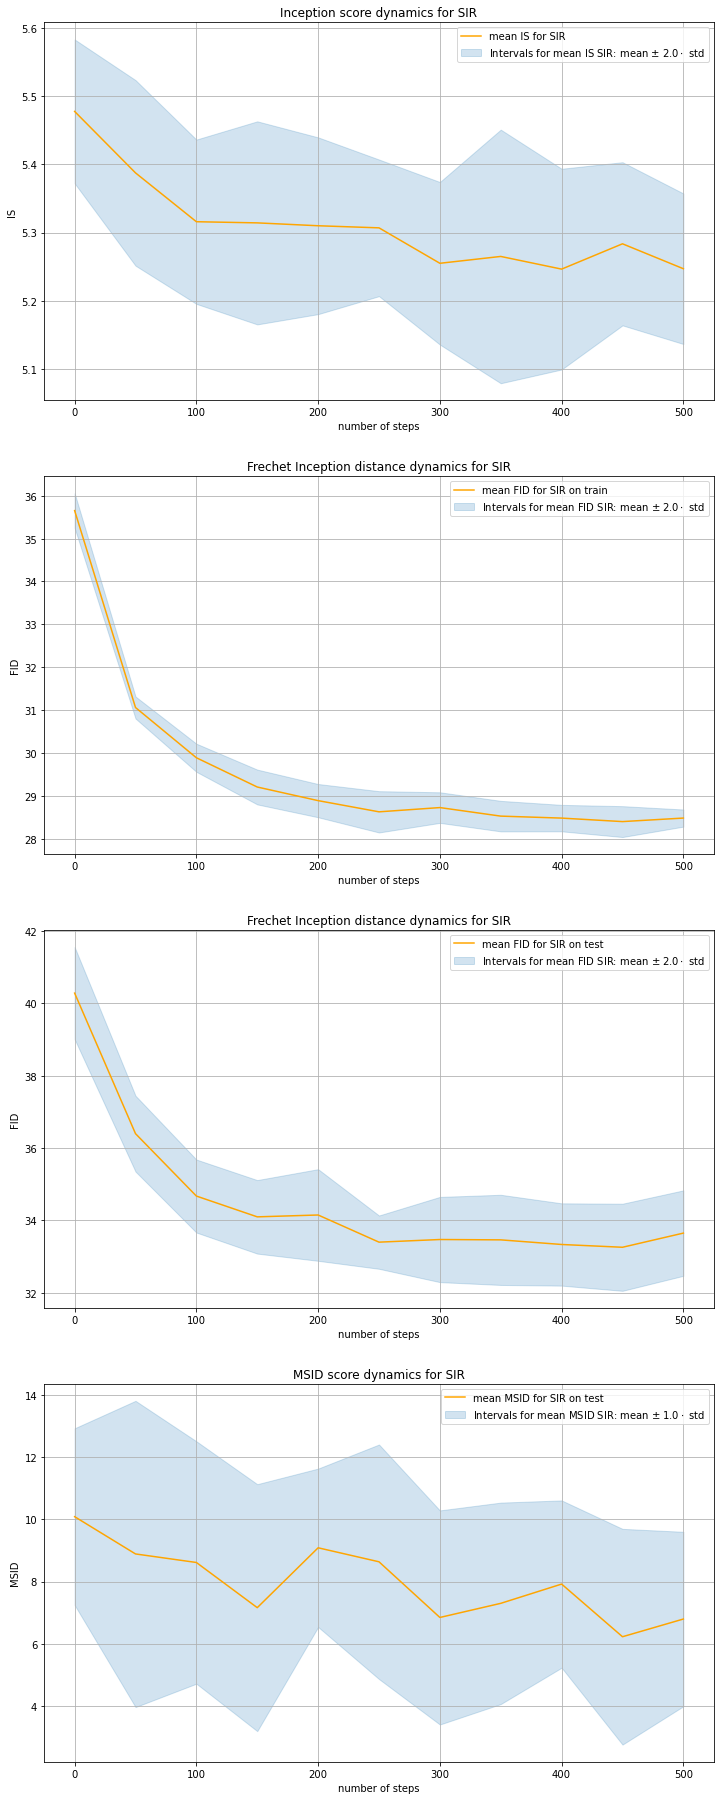

In [5]:
plot_is_fid_msid = [True, True, True, True]
stds_coef = [2.0, 2.0, 2.0, 1.0]
start_plot = None
every_step = 50
method_name = "SIR"
figsize = (12, 8)
file_names = None

axs, fig, cur_file_names = plot_scores_dynamics(scores=dict_results,
                                           every_step=every_step, 
                                           method_name=method_name,
                                           figsize=figsize,
                                           path_to_save=path_to_save,
                                           start_plot=start_plot,
                                           stds_coef = stds_coef,
                                           plot_is_fid_msid=plot_is_fid_msid,
                                           file_names = file_names)

In [6]:
method_name = 'ula_dcgan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
dict_results_ula = load_dict_stats(method_name, path_to_save)

In [7]:
plot_is_fid_msid = [True, True, True, True]
stds_coef = [2.0, 2.0, 2.0, 1.0]
start_plot = axs
every_step = 50
method_name = "ULA"
file_names = cur_file_names
color_conf = "C1"
color_mean = "green"

axs_new, new_fig, new_file_names = plot_scores_dynamics(scores=dict_results_ula,
                                           every_step=every_step, 
                                           method_name=method_name,
                                           path_to_save=path_to_save,
                                           start_plot=start_plot,
                                           fig_plot = fig,
                                           stds_coef = stds_coef,
                                           plot_is_fid_msid=plot_is_fid_msid,
                                           file_names = file_names,
                                           color_conf = color_conf,
                                           color_mean = color_mean)

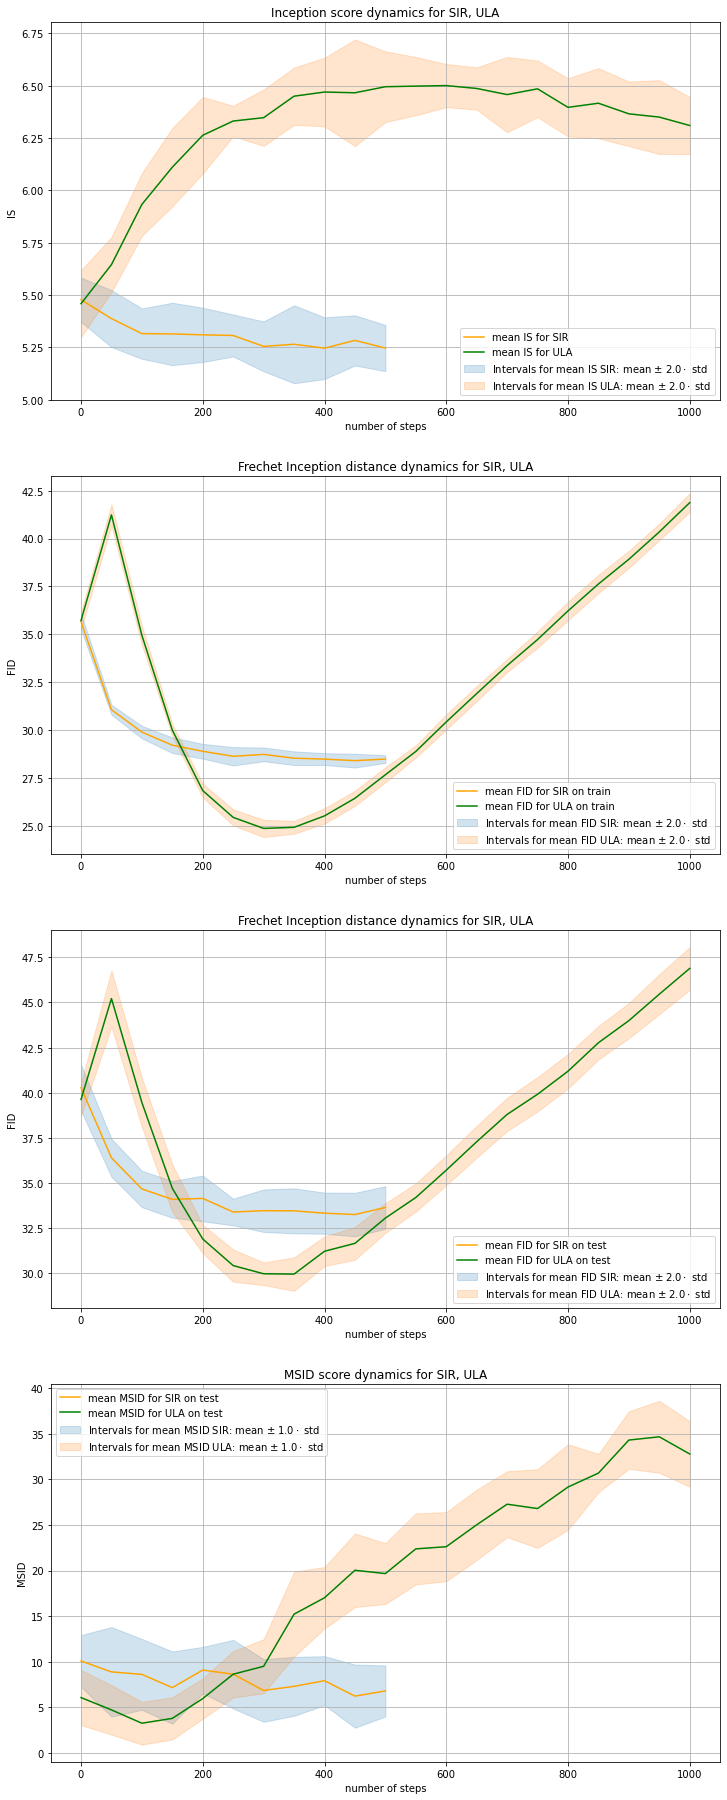

In [8]:
new_fig

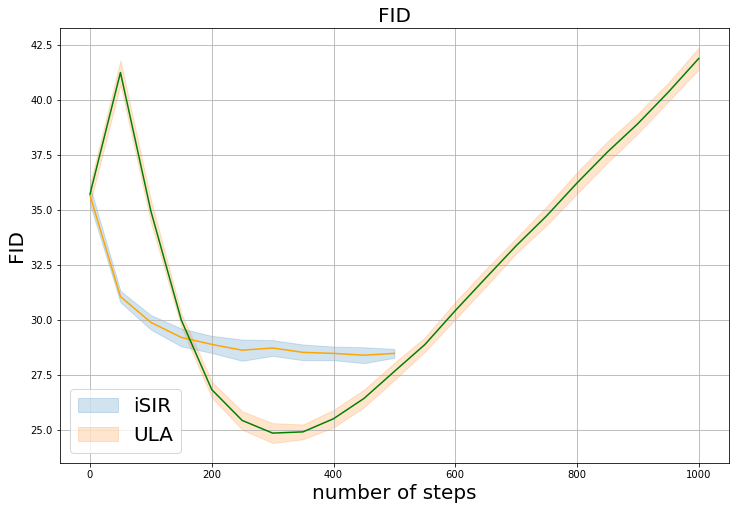

In [34]:
xlabels = ["IS", "FID", "FID", "MSID"]
mean_names = ["inception_scores_mean", "fid_scores_mean_train",
              "fid_scores_mean_test", "msid_scores_mean_test"]
std_names = ["inception_scores_std", "fid_scores_std_train",
             "fid_scores_std_test", "msid_scores_std_test"]
titles = ["Inception score", "Frechet Inception distance",
          "Frechet Inception distance", "MSID score"]
train_test_mode = ["", "on train", "on test", "on test"]
stds_coef = [2.0, 2.0, 2.0, 1.0]
start_plot = None
every_step = 50
method_name = "iSIR"
color_conf="C0"
color_mean="orange"

i = 1
scores = dict_results

fig, axs = plt.subplots(1, 1, figsize=(12, 8))

range_steps = [i * every_step for i in range(len(scores[mean_names[i]]))]
axs.plot(range_steps, scores[mean_names[i]], c=color_mean)
axs.fill_between(range_steps,
                           scores[mean_names[i]] - stds_coef[i] * scores[std_names[i]],
                           scores[mean_names[i]] + stds_coef[i] * scores[std_names[i]],
                           color=color_conf,
                           alpha=0.2,
                           label=fr'{method_name}')
if start_plot is None:
    axs.set_xlabel("number of steps", fontsize=20)
    axs.set_ylabel(xlabels[i], fontsize=20)
    axs.set_title(f"{titles[i]} dynamics for {method_name}")
    axs.grid(True)
    name_mean = f'{method_name}_{mean_names[i]}.pdf'
else:
    title = axs.get_title()
    title += f", {method_name}"
    axs.set_title(title)
    name_mean = f"{method_name}_" + file_names[ind_plot]

stds_coef = [2.0, 2.0, 2.0, 1.0]
every_step = 50
method_name = "ULA"
color_conf = "C1"
color_mean = "green"
start_plot = axs

i = 1
scores = dict_results_ula

range_steps = [i * every_step for i in range(len(scores[mean_names[i]]))]
axs.plot(range_steps, scores[mean_names[i]], c=color_mean)
axs.fill_between(range_steps,
                           scores[mean_names[i]] - stds_coef[i] * scores[std_names[i]],
                           scores[mean_names[i]] + stds_coef[i] * scores[std_names[i]],
                           color=color_conf,
                           alpha=0.2,
                           label=fr'{method_name}')
if start_plot is None:
    axs.set_xlabel("number of steps")
    axs.set_ylabel(xlabels[i])
    axs.set_title(f"FID")
    axs.grid(True)
    name_mean = f'{method_name}_{mean_names[i]}.pdf'
else:
    title = "FID"
    axs.set_title(title, fontsize=20)

axs.legend(fontsize=20)
path_to_save = '/home/daniil/pycharm_dir/gans_sampling/figs/fid_cifar_isir_ula.pdf'
fig.savefig(path_to_save)
plt.show()

In [5]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
method_name = 'sir_dcgan_cifar_recalc_stats_1000_steps'

dict_results_isir = load_dict_stats(method_name, path_to_save)

In [7]:
i = 0
step = 50
start = 0
while start != 650:
    start += step
    i += 1

In [8]:
i

13

In [10]:
dict_results_isir['fid_scores_mean_train']

array([35.83208154, 31.02390819, 29.72230738, 29.05701634, 28.8082389 ,
       28.61166558, 28.44943935, 28.52974428, 28.53847647, 28.44650493,
       28.51697227, 28.50065948, 28.5188353 , 28.70381739, 28.62890427,
       28.46638714, 28.6147149 , 28.74685154, 28.69432856, 28.6033011 ,
       28.63888781])

In [9]:
dict_results_isir['fid_scores_mean_train'][13]

28.70381739412459

In [18]:
dict_results_isir['fid_scores_std_train'][13]

0.1414696366662793

In [11]:
method_name = 'ula_dcgan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
dict_results_ula = load_dict_stats(method_name, path_to_save)

In [13]:
dict_results_ula['fid_scores_mean_train'][13]

31.89948226894047

In [14]:
dict_results_ula['fid_scores_std_train'][13]

0.1971615980714933

In [20]:
dict_results_ula['fid_scores_mean_train']

array([35.71696744, 41.23658666, 34.94264839, 29.99145377, 26.83238766,
       25.4330189 , 24.85777145, 24.91446835, 25.51014069, 26.43138298,
       27.65998465, 28.87746921, 30.41964352, 31.89948227, 33.36489927,
       34.72285885, 36.21797335, 37.6261386 , 38.9148296 , 40.3451899 ,
       41.87512163])

In [15]:
dict_results_ula['fid_scores_mean_train'][0]

35.716967444687825

In [17]:
dict_results_ula['fid_scores_std_train'][0]

0.22371321329750932

## CISIR

In [7]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 50000
n_steps = 201
N = 5
alpha = 0.95

method_name = 'cisir_dcgan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_alpha_{alpha}_nsteps_{n_steps}'
every_step = 40
continue_z = None

z_last_np, zs = sir_correlated_sampling(target_gan, proposal, batch_size, n,
                                        path_to_save, file_name, every_step,
                                        continue_z, n_steps, N, alpha)

  0%|          | 1/250 [00:27<1:55:01, 27.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_0.npy was saved, file shape = (6, 200, 100)


  1%|          | 2/250 [00:56<1:55:55, 28.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_200.npy was saved, file shape = (6, 200, 100)


  1%|          | 3/250 [01:25<1:56:46, 28.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_400.npy was saved, file shape = (6, 200, 100)


  2%|▏         | 4/250 [01:54<1:57:03, 28.55s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_600.npy was saved, file shape = (6, 200, 100)


  2%|▏         | 5/250 [02:23<1:56:58, 28.65s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_800.npy was saved, file shape = (6, 200, 100)


  2%|▏         | 6/250 [02:52<1:56:39, 28.69s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_1000.npy was saved, file shape = (6, 200, 100)


  3%|▎         | 7/250 [03:21<1:56:16, 28.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_1200.npy was saved, file shape = (6, 200, 100)


  3%|▎         | 8/250 [03:49<1:55:47, 28.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_1400.npy was saved, file shape = (6, 200, 100)


  4%|▎         | 9/250 [04:18<1:55:17, 28.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_1600.npy was saved, file shape = (6, 200, 100)


  4%|▍         | 10/250 [04:47<1:54:49, 28.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_1800.npy was saved, file shape = (6, 200, 100)


  4%|▍         | 11/250 [05:15<1:54:23, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_2000.npy was saved, file shape = (6, 200, 100)


  5%|▍         | 12/250 [05:44<1:53:58, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_2200.npy was saved, file shape = (6, 200, 100)


  5%|▌         | 13/250 [06:13<1:53:34, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_2400.npy was saved, file shape = (6, 200, 100)


  6%|▌         | 14/250 [06:42<1:53:09, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_2600.npy was saved, file shape = (6, 200, 100)


  6%|▌         | 15/250 [07:11<1:52:43, 28.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_2800.npy was saved, file shape = (6, 200, 100)


  6%|▋         | 16/250 [07:39<1:52:11, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_3000.npy was saved, file shape = (6, 200, 100)


  7%|▋         | 17/250 [08:08<1:51:38, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_3200.npy was saved, file shape = (6, 200, 100)


  7%|▋         | 18/250 [08:37<1:51:07, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_3400.npy was saved, file shape = (6, 200, 100)


  8%|▊         | 19/250 [09:05<1:50:36, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_3600.npy was saved, file shape = (6, 200, 100)


  8%|▊         | 20/250 [09:34<1:50:05, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_3800.npy was saved, file shape = (6, 200, 100)


  8%|▊         | 21/250 [10:03<1:49:35, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_4000.npy was saved, file shape = (6, 200, 100)


  9%|▉         | 22/250 [10:32<1:49:04, 28.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_4200.npy was saved, file shape = (6, 200, 100)


  9%|▉         | 23/250 [11:00<1:48:38, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_4400.npy was saved, file shape = (6, 200, 100)


 10%|▉         | 24/250 [11:29<1:48:11, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_4600.npy was saved, file shape = (6, 200, 100)


 10%|█         | 25/250 [11:58<1:47:46, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_4800.npy was saved, file shape = (6, 200, 100)


 10%|█         | 26/250 [12:27<1:47:19, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_5000.npy was saved, file shape = (6, 200, 100)


 11%|█         | 27/250 [12:55<1:46:51, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_5200.npy was saved, file shape = (6, 200, 100)


 11%|█         | 28/250 [13:24<1:46:24, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_5400.npy was saved, file shape = (6, 200, 100)


 12%|█▏        | 29/250 [13:53<1:45:53, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_5600.npy was saved, file shape = (6, 200, 100)


 12%|█▏        | 30/250 [14:22<1:45:23, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_5800.npy was saved, file shape = (6, 200, 100)


 12%|█▏        | 31/250 [14:50<1:44:53, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_6000.npy was saved, file shape = (6, 200, 100)


 13%|█▎        | 32/250 [15:19<1:44:22, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_6200.npy was saved, file shape = (6, 200, 100)


 13%|█▎        | 33/250 [15:48<1:43:54, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_6400.npy was saved, file shape = (6, 200, 100)


 14%|█▎        | 34/250 [16:16<1:43:24, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_6600.npy was saved, file shape = (6, 200, 100)


 14%|█▍        | 35/250 [16:45<1:42:56, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_6800.npy was saved, file shape = (6, 200, 100)


 14%|█▍        | 36/250 [17:14<1:42:28, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_7000.npy was saved, file shape = (6, 200, 100)


 15%|█▍        | 37/250 [17:43<1:41:59, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_7200.npy was saved, file shape = (6, 200, 100)


 15%|█▌        | 38/250 [18:11<1:41:31, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_7400.npy was saved, file shape = (6, 200, 100)


 16%|█▌        | 39/250 [18:40<1:41:03, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_7600.npy was saved, file shape = (6, 200, 100)


 16%|█▌        | 40/250 [19:09<1:40:36, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_7800.npy was saved, file shape = (6, 200, 100)


 16%|█▋        | 41/250 [19:38<1:40:07, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_8000.npy was saved, file shape = (6, 200, 100)


 17%|█▋        | 42/250 [20:06<1:39:39, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_8200.npy was saved, file shape = (6, 200, 100)


 17%|█▋        | 43/250 [20:35<1:39:10, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_8400.npy was saved, file shape = (6, 200, 100)


 18%|█▊        | 44/250 [21:04<1:38:41, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_8600.npy was saved, file shape = (6, 200, 100)


 18%|█▊        | 45/250 [21:33<1:38:12, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_8800.npy was saved, file shape = (6, 200, 100)


 18%|█▊        | 46/250 [22:01<1:37:43, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_9000.npy was saved, file shape = (6, 200, 100)


 19%|█▉        | 47/250 [22:30<1:37:13, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_9200.npy was saved, file shape = (6, 200, 100)


 19%|█▉        | 48/250 [22:59<1:36:45, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_9400.npy was saved, file shape = (6, 200, 100)


 20%|█▉        | 49/250 [23:28<1:36:17, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_9600.npy was saved, file shape = (6, 200, 100)


 20%|██        | 50/250 [23:56<1:35:48, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_9800.npy was saved, file shape = (6, 200, 100)


 20%|██        | 51/250 [24:25<1:35:19, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_10000.npy was saved, file shape = (6, 200, 100)


 21%|██        | 52/250 [24:54<1:34:49, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_10200.npy was saved, file shape = (6, 200, 100)


 21%|██        | 53/250 [25:23<1:34:22, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_10400.npy was saved, file shape = (6, 200, 100)


 22%|██▏       | 54/250 [25:51<1:33:51, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_10600.npy was saved, file shape = (6, 200, 100)


 22%|██▏       | 55/250 [26:20<1:33:20, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_10800.npy was saved, file shape = (6, 200, 100)


 22%|██▏       | 56/250 [26:49<1:32:55, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_11000.npy was saved, file shape = (6, 200, 100)


 23%|██▎       | 57/250 [27:17<1:32:26, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_11200.npy was saved, file shape = (6, 200, 100)


 23%|██▎       | 58/250 [27:46<1:31:58, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_11400.npy was saved, file shape = (6, 200, 100)


 24%|██▎       | 59/250 [28:15<1:31:30, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_11600.npy was saved, file shape = (6, 200, 100)


 24%|██▍       | 60/250 [28:44<1:31:02, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_11800.npy was saved, file shape = (6, 200, 100)


 24%|██▍       | 61/250 [29:12<1:30:33, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_12000.npy was saved, file shape = (6, 200, 100)


 25%|██▍       | 62/250 [29:41<1:30:03, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_12200.npy was saved, file shape = (6, 200, 100)


 25%|██▌       | 63/250 [30:10<1:29:33, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_12400.npy was saved, file shape = (6, 200, 100)


 26%|██▌       | 64/250 [30:39<1:29:02, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_12600.npy was saved, file shape = (6, 200, 100)


 26%|██▌       | 65/250 [31:07<1:28:34, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_12800.npy was saved, file shape = (6, 200, 100)


 26%|██▋       | 66/250 [31:36<1:28:06, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_13000.npy was saved, file shape = (6, 200, 100)


 27%|██▋       | 67/250 [32:05<1:27:38, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_13200.npy was saved, file shape = (6, 200, 100)


 27%|██▋       | 68/250 [32:34<1:27:12, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_13400.npy was saved, file shape = (6, 200, 100)


 28%|██▊       | 69/250 [33:02<1:26:44, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_13600.npy was saved, file shape = (6, 200, 100)


 28%|██▊       | 70/250 [33:31<1:26:15, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_13800.npy was saved, file shape = (6, 200, 100)


 28%|██▊       | 71/250 [34:00<1:25:48, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_14000.npy was saved, file shape = (6, 200, 100)


 29%|██▉       | 72/250 [34:29<1:25:18, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_14200.npy was saved, file shape = (6, 200, 100)


 29%|██▉       | 73/250 [34:57<1:24:49, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_14400.npy was saved, file shape = (6, 200, 100)


 30%|██▉       | 74/250 [35:26<1:24:19, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_14600.npy was saved, file shape = (6, 200, 100)


 30%|███       | 75/250 [35:55<1:23:49, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_14800.npy was saved, file shape = (6, 200, 100)


 30%|███       | 76/250 [36:24<1:23:20, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_15000.npy was saved, file shape = (6, 200, 100)


 31%|███       | 77/250 [36:52<1:22:51, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_15200.npy was saved, file shape = (6, 200, 100)


 31%|███       | 78/250 [37:21<1:22:24, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_15400.npy was saved, file shape = (6, 200, 100)


 32%|███▏      | 79/250 [37:50<1:21:55, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_15600.npy was saved, file shape = (6, 200, 100)


 32%|███▏      | 80/250 [38:19<1:21:26, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_15800.npy was saved, file shape = (6, 200, 100)


 32%|███▏      | 81/250 [38:47<1:20:58, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_16000.npy was saved, file shape = (6, 200, 100)


 33%|███▎      | 82/250 [39:16<1:20:29, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_16200.npy was saved, file shape = (6, 200, 100)


 33%|███▎      | 83/250 [39:45<1:20:00, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_16400.npy was saved, file shape = (6, 200, 100)


 34%|███▎      | 84/250 [40:14<1:19:33, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_16600.npy was saved, file shape = (6, 200, 100)


 34%|███▍      | 85/250 [40:42<1:19:04, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_16800.npy was saved, file shape = (6, 200, 100)


 34%|███▍      | 86/250 [41:11<1:18:36, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_17000.npy was saved, file shape = (6, 200, 100)


 35%|███▍      | 87/250 [41:40<1:18:08, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_17200.npy was saved, file shape = (6, 200, 100)


 35%|███▌      | 88/250 [42:09<1:17:40, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_17400.npy was saved, file shape = (6, 200, 100)


 36%|███▌      | 89/250 [42:37<1:17:12, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_17600.npy was saved, file shape = (6, 200, 100)


 36%|███▌      | 90/250 [43:06<1:16:42, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_17800.npy was saved, file shape = (6, 200, 100)


 36%|███▋      | 91/250 [43:35<1:16:12, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_18000.npy was saved, file shape = (6, 200, 100)


 37%|███▋      | 92/250 [44:04<1:15:43, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_18200.npy was saved, file shape = (6, 200, 100)


 37%|███▋      | 93/250 [44:32<1:15:13, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_18400.npy was saved, file shape = (6, 200, 100)


 38%|███▊      | 94/250 [45:01<1:14:44, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_18600.npy was saved, file shape = (6, 200, 100)


 38%|███▊      | 95/250 [45:30<1:14:17, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_18800.npy was saved, file shape = (6, 200, 100)


 38%|███▊      | 96/250 [45:59<1:13:48, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_19000.npy was saved, file shape = (6, 200, 100)


 39%|███▉      | 97/250 [46:27<1:13:19, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_19200.npy was saved, file shape = (6, 200, 100)


 39%|███▉      | 98/250 [46:56<1:12:50, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_19400.npy was saved, file shape = (6, 200, 100)


 40%|███▉      | 99/250 [47:25<1:12:23, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_19600.npy was saved, file shape = (6, 200, 100)


 40%|████      | 100/250 [47:54<1:11:53, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_19800.npy was saved, file shape = (6, 200, 100)


 40%|████      | 101/250 [48:22<1:11:23, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_20000.npy was saved, file shape = (6, 200, 100)


 41%|████      | 102/250 [48:51<1:10:56, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_20200.npy was saved, file shape = (6, 200, 100)


 41%|████      | 103/250 [49:20<1:10:27, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_20400.npy was saved, file shape = (6, 200, 100)


 42%|████▏     | 104/250 [49:49<1:09:59, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_20600.npy was saved, file shape = (6, 200, 100)


 42%|████▏     | 105/250 [50:18<1:09:30, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_20800.npy was saved, file shape = (6, 200, 100)


 42%|████▏     | 106/250 [50:46<1:09:02, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_21000.npy was saved, file shape = (6, 200, 100)


 43%|████▎     | 107/250 [51:15<1:08:32, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_21200.npy was saved, file shape = (6, 200, 100)


 43%|████▎     | 108/250 [51:44<1:08:02, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_21400.npy was saved, file shape = (6, 200, 100)


 44%|████▎     | 109/250 [52:13<1:07:34, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_21600.npy was saved, file shape = (6, 200, 100)


 44%|████▍     | 110/250 [52:41<1:07:05, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_21800.npy was saved, file shape = (6, 200, 100)


 44%|████▍     | 111/250 [53:10<1:06:36, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_22000.npy was saved, file shape = (6, 200, 100)


 45%|████▍     | 112/250 [53:39<1:06:07, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_22200.npy was saved, file shape = (6, 200, 100)


 45%|████▌     | 113/250 [54:08<1:05:39, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_22400.npy was saved, file shape = (6, 200, 100)


 46%|████▌     | 114/250 [54:36<1:05:09, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_22600.npy was saved, file shape = (6, 200, 100)


 46%|████▌     | 115/250 [55:05<1:04:39, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_22800.npy was saved, file shape = (6, 200, 100)


 46%|████▋     | 116/250 [55:34<1:04:11, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_23000.npy was saved, file shape = (6, 200, 100)


 47%|████▋     | 117/250 [56:02<1:03:41, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_23200.npy was saved, file shape = (6, 200, 100)


 47%|████▋     | 118/250 [56:31<1:03:11, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_23400.npy was saved, file shape = (6, 200, 100)


 48%|████▊     | 119/250 [57:00<1:02:42, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_23600.npy was saved, file shape = (6, 200, 100)


 48%|████▊     | 120/250 [57:29<1:02:13, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_23800.npy was saved, file shape = (6, 200, 100)


 48%|████▊     | 121/250 [57:57<1:01:46, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_24000.npy was saved, file shape = (6, 200, 100)


 49%|████▉     | 122/250 [58:26<1:01:16, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_24200.npy was saved, file shape = (6, 200, 100)


 49%|████▉     | 123/250 [58:55<1:00:49, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_24400.npy was saved, file shape = (6, 200, 100)


 50%|████▉     | 124/250 [59:24<1:00:20, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_24600.npy was saved, file shape = (6, 200, 100)


 50%|█████     | 125/250 [59:52<59:52, 28.74s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_24800.npy was saved, file shape = (6, 200, 100)


 50%|█████     | 126/250 [1:00:21<59:23, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_25000.npy was saved, file shape = (6, 200, 100)


 51%|█████     | 127/250 [1:00:50<58:54, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_25200.npy was saved, file shape = (6, 200, 100)


 51%|█████     | 128/250 [1:01:19<58:25, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_25400.npy was saved, file shape = (6, 200, 100)


 52%|█████▏    | 129/250 [1:01:47<57:56, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_25600.npy was saved, file shape = (6, 200, 100)


 52%|█████▏    | 130/250 [1:02:16<57:28, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_25800.npy was saved, file shape = (6, 200, 100)


 52%|█████▏    | 131/250 [1:02:45<57:00, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_26000.npy was saved, file shape = (6, 200, 100)


 53%|█████▎    | 132/250 [1:03:14<56:31, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_26200.npy was saved, file shape = (6, 200, 100)


 53%|█████▎    | 133/250 [1:03:42<56:01, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_26400.npy was saved, file shape = (6, 200, 100)


 54%|█████▎    | 134/250 [1:04:11<55:34, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_26600.npy was saved, file shape = (6, 200, 100)


 54%|█████▍    | 135/250 [1:04:40<55:05, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_26800.npy was saved, file shape = (6, 200, 100)


 54%|█████▍    | 136/250 [1:05:08<54:37, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_27000.npy was saved, file shape = (6, 200, 100)


 55%|█████▍    | 137/250 [1:05:37<54:08, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_27200.npy was saved, file shape = (6, 200, 100)


 55%|█████▌    | 138/250 [1:06:06<53:39, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_27400.npy was saved, file shape = (6, 200, 100)


 56%|█████▌    | 139/250 [1:06:35<53:10, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_27600.npy was saved, file shape = (6, 200, 100)


 56%|█████▌    | 140/250 [1:07:03<52:41, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_27800.npy was saved, file shape = (6, 200, 100)


 56%|█████▋    | 141/250 [1:07:32<52:13, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_28000.npy was saved, file shape = (6, 200, 100)


 57%|█████▋    | 142/250 [1:08:01<51:44, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_28200.npy was saved, file shape = (6, 200, 100)


 57%|█████▋    | 143/250 [1:08:30<51:15, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_28400.npy was saved, file shape = (6, 200, 100)


 58%|█████▊    | 144/250 [1:08:58<50:46, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_28600.npy was saved, file shape = (6, 200, 100)


 58%|█████▊    | 145/250 [1:09:27<50:18, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_28800.npy was saved, file shape = (6, 200, 100)


 58%|█████▊    | 146/250 [1:09:56<49:49, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_29000.npy was saved, file shape = (6, 200, 100)


 59%|█████▉    | 147/250 [1:10:25<49:21, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_29200.npy was saved, file shape = (6, 200, 100)


 59%|█████▉    | 148/250 [1:10:53<48:52, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_29400.npy was saved, file shape = (6, 200, 100)


 60%|█████▉    | 149/250 [1:11:22<48:23, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_29600.npy was saved, file shape = (6, 200, 100)


 60%|██████    | 150/250 [1:11:51<47:54, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_29800.npy was saved, file shape = (6, 200, 100)


 60%|██████    | 151/250 [1:12:20<47:26, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_30000.npy was saved, file shape = (6, 200, 100)


 61%|██████    | 152/250 [1:12:48<46:56, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_30200.npy was saved, file shape = (6, 200, 100)


 61%|██████    | 153/250 [1:13:17<46:27, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_30400.npy was saved, file shape = (6, 200, 100)


 62%|██████▏   | 154/250 [1:13:46<45:58, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_30600.npy was saved, file shape = (6, 200, 100)


 62%|██████▏   | 155/250 [1:14:15<45:29, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_30800.npy was saved, file shape = (6, 200, 100)


 62%|██████▏   | 156/250 [1:14:43<45:00, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_31000.npy was saved, file shape = (6, 200, 100)


 63%|██████▎   | 157/250 [1:15:12<44:31, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_31200.npy was saved, file shape = (6, 200, 100)


 63%|██████▎   | 158/250 [1:15:41<44:02, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_31400.npy was saved, file shape = (6, 200, 100)


 64%|██████▎   | 159/250 [1:16:09<43:34, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_31600.npy was saved, file shape = (6, 200, 100)


 64%|██████▍   | 160/250 [1:16:38<43:06, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_31800.npy was saved, file shape = (6, 200, 100)


 64%|██████▍   | 161/250 [1:17:07<42:37, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_32000.npy was saved, file shape = (6, 200, 100)


 65%|██████▍   | 162/250 [1:17:36<42:08, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_32200.npy was saved, file shape = (6, 200, 100)


 65%|██████▌   | 163/250 [1:18:04<41:39, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_32400.npy was saved, file shape = (6, 200, 100)


 66%|██████▌   | 164/250 [1:18:33<41:11, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_32600.npy was saved, file shape = (6, 200, 100)


 66%|██████▌   | 165/250 [1:19:02<40:43, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_32800.npy was saved, file shape = (6, 200, 100)


 66%|██████▋   | 166/250 [1:19:31<40:14, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_33000.npy was saved, file shape = (6, 200, 100)


 67%|██████▋   | 167/250 [1:19:59<39:46, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_33200.npy was saved, file shape = (6, 200, 100)


 67%|██████▋   | 168/250 [1:20:28<39:16, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_33400.npy was saved, file shape = (6, 200, 100)


 68%|██████▊   | 169/250 [1:20:57<38:47, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_33600.npy was saved, file shape = (6, 200, 100)


 68%|██████▊   | 170/250 [1:21:26<38:18, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_33800.npy was saved, file shape = (6, 200, 100)


 68%|██████▊   | 171/250 [1:21:54<37:49, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_34000.npy was saved, file shape = (6, 200, 100)


 69%|██████▉   | 172/250 [1:22:23<37:20, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_34200.npy was saved, file shape = (6, 200, 100)


 69%|██████▉   | 173/250 [1:22:52<36:52, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_34400.npy was saved, file shape = (6, 200, 100)


 70%|██████▉   | 174/250 [1:23:21<36:23, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_34600.npy was saved, file shape = (6, 200, 100)


 70%|███████   | 175/250 [1:23:49<35:55, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_34800.npy was saved, file shape = (6, 200, 100)


 70%|███████   | 176/250 [1:24:18<35:26, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_35000.npy was saved, file shape = (6, 200, 100)


 71%|███████   | 177/250 [1:24:47<34:57, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_35200.npy was saved, file shape = (6, 200, 100)


 71%|███████   | 178/250 [1:25:16<34:29, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_35400.npy was saved, file shape = (6, 200, 100)


 72%|███████▏  | 179/250 [1:25:44<34:00, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_35600.npy was saved, file shape = (6, 200, 100)


 72%|███████▏  | 180/250 [1:26:13<33:31, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_35800.npy was saved, file shape = (6, 200, 100)


 72%|███████▏  | 181/250 [1:26:42<33:02, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_36000.npy was saved, file shape = (6, 200, 100)


 73%|███████▎  | 182/250 [1:27:10<32:33, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_36200.npy was saved, file shape = (6, 200, 100)


 73%|███████▎  | 183/250 [1:27:39<32:05, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_36400.npy was saved, file shape = (6, 200, 100)


 74%|███████▎  | 184/250 [1:28:08<31:37, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_36600.npy was saved, file shape = (6, 200, 100)


 74%|███████▍  | 185/250 [1:28:37<31:08, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_36800.npy was saved, file shape = (6, 200, 100)


 74%|███████▍  | 186/250 [1:29:05<30:39, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_37000.npy was saved, file shape = (6, 200, 100)


 75%|███████▍  | 187/250 [1:29:34<30:10, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_37200.npy was saved, file shape = (6, 200, 100)


 75%|███████▌  | 188/250 [1:30:03<29:42, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_37400.npy was saved, file shape = (6, 200, 100)


 76%|███████▌  | 189/250 [1:30:32<29:13, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_37600.npy was saved, file shape = (6, 200, 100)


 76%|███████▌  | 190/250 [1:31:00<28:44, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_37800.npy was saved, file shape = (6, 200, 100)


 76%|███████▋  | 191/250 [1:31:29<28:16, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_38000.npy was saved, file shape = (6, 200, 100)


 77%|███████▋  | 192/250 [1:31:58<27:47, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_38200.npy was saved, file shape = (6, 200, 100)


 77%|███████▋  | 193/250 [1:32:27<27:18, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_38400.npy was saved, file shape = (6, 200, 100)


 78%|███████▊  | 194/250 [1:32:55<26:49, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_38600.npy was saved, file shape = (6, 200, 100)


 78%|███████▊  | 195/250 [1:33:24<26:20, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_38800.npy was saved, file shape = (6, 200, 100)


 78%|███████▊  | 196/250 [1:33:53<25:51, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_39000.npy was saved, file shape = (6, 200, 100)


 79%|███████▉  | 197/250 [1:34:22<25:23, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_39200.npy was saved, file shape = (6, 200, 100)


 79%|███████▉  | 198/250 [1:34:50<24:55, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_39400.npy was saved, file shape = (6, 200, 100)


 80%|███████▉  | 199/250 [1:35:19<24:26, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_39600.npy was saved, file shape = (6, 200, 100)


 80%|████████  | 200/250 [1:35:48<23:58, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_39800.npy was saved, file shape = (6, 200, 100)


 80%|████████  | 201/250 [1:36:17<23:29, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_40000.npy was saved, file shape = (6, 200, 100)


 81%|████████  | 202/250 [1:36:45<23:00, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_40200.npy was saved, file shape = (6, 200, 100)


 81%|████████  | 203/250 [1:37:14<22:31, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_40400.npy was saved, file shape = (6, 200, 100)


 82%|████████▏ | 204/250 [1:37:43<22:02, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_40600.npy was saved, file shape = (6, 200, 100)


 82%|████████▏ | 205/250 [1:38:12<21:33, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_40800.npy was saved, file shape = (6, 200, 100)


 82%|████████▏ | 206/250 [1:38:40<21:04, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_41000.npy was saved, file shape = (6, 200, 100)


 83%|████████▎ | 207/250 [1:39:09<20:35, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_41200.npy was saved, file shape = (6, 200, 100)


 83%|████████▎ | 208/250 [1:39:38<20:07, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_41400.npy was saved, file shape = (6, 200, 100)


 84%|████████▎ | 209/250 [1:40:07<19:38, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_41600.npy was saved, file shape = (6, 200, 100)


 84%|████████▍ | 210/250 [1:40:35<19:09, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_41800.npy was saved, file shape = (6, 200, 100)


 84%|████████▍ | 211/250 [1:41:04<18:41, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_42000.npy was saved, file shape = (6, 200, 100)


 85%|████████▍ | 212/250 [1:41:33<18:12, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_42200.npy was saved, file shape = (6, 200, 100)


 85%|████████▌ | 213/250 [1:42:02<17:43, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_42400.npy was saved, file shape = (6, 200, 100)


 86%|████████▌ | 214/250 [1:42:30<17:15, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_42600.npy was saved, file shape = (6, 200, 100)


 86%|████████▌ | 215/250 [1:42:59<16:46, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_42800.npy was saved, file shape = (6, 200, 100)


 86%|████████▋ | 216/250 [1:43:28<16:17, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_43000.npy was saved, file shape = (6, 200, 100)


 87%|████████▋ | 217/250 [1:43:57<15:48, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_43200.npy was saved, file shape = (6, 200, 100)


 87%|████████▋ | 218/250 [1:44:25<15:19, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_43400.npy was saved, file shape = (6, 200, 100)


 88%|████████▊ | 219/250 [1:44:54<14:51, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_43600.npy was saved, file shape = (6, 200, 100)


 88%|████████▊ | 220/250 [1:45:23<14:22, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_43800.npy was saved, file shape = (6, 200, 100)


 88%|████████▊ | 221/250 [1:45:52<13:53, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_44000.npy was saved, file shape = (6, 200, 100)


 89%|████████▉ | 222/250 [1:46:20<13:24, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_44200.npy was saved, file shape = (6, 200, 100)


 89%|████████▉ | 223/250 [1:46:49<12:55, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_44400.npy was saved, file shape = (6, 200, 100)


 90%|████████▉ | 224/250 [1:47:18<12:26, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_44600.npy was saved, file shape = (6, 200, 100)


 90%|█████████ | 225/250 [1:47:47<11:58, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_44800.npy was saved, file shape = (6, 200, 100)


 90%|█████████ | 226/250 [1:48:15<11:29, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_45000.npy was saved, file shape = (6, 200, 100)


 91%|█████████ | 227/250 [1:48:44<11:01, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_45200.npy was saved, file shape = (6, 200, 100)


 91%|█████████ | 228/250 [1:49:13<10:32, 28.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_45400.npy was saved, file shape = (6, 200, 100)


 92%|█████████▏| 229/250 [1:49:42<10:04, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_45600.npy was saved, file shape = (6, 200, 100)


 92%|█████████▏| 230/250 [1:50:10<09:35, 28.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_45800.npy was saved, file shape = (6, 200, 100)


 92%|█████████▏| 231/250 [1:50:39<09:06, 28.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_46000.npy was saved, file shape = (6, 200, 100)


 93%|█████████▎| 232/250 [1:51:08<08:37, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_46200.npy was saved, file shape = (6, 200, 100)


 93%|█████████▎| 233/250 [1:51:37<08:08, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_46400.npy was saved, file shape = (6, 200, 100)


 94%|█████████▎| 234/250 [1:52:05<07:39, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_46600.npy was saved, file shape = (6, 200, 100)


 94%|█████████▍| 235/250 [1:52:34<07:10, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_46800.npy was saved, file shape = (6, 200, 100)


 94%|█████████▍| 236/250 [1:53:03<06:41, 28.71s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_47000.npy was saved, file shape = (6, 200, 100)


 95%|█████████▍| 237/250 [1:53:31<06:13, 28.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_47200.npy was saved, file shape = (6, 200, 100)


 95%|█████████▌| 238/250 [1:54:00<05:44, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_47400.npy was saved, file shape = (6, 200, 100)


 96%|█████████▌| 239/250 [1:54:29<05:16, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_47600.npy was saved, file shape = (6, 200, 100)


 96%|█████████▌| 240/250 [1:54:58<04:47, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_47800.npy was saved, file shape = (6, 200, 100)


 96%|█████████▋| 241/250 [1:55:26<04:18, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_48000.npy was saved, file shape = (6, 200, 100)


 97%|█████████▋| 242/250 [1:55:55<03:50, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_48200.npy was saved, file shape = (6, 200, 100)


 97%|█████████▋| 243/250 [1:56:24<03:21, 28.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_48400.npy was saved, file shape = (6, 200, 100)


 98%|█████████▊| 244/250 [1:56:53<02:52, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_48600.npy was saved, file shape = (6, 200, 100)


 98%|█████████▊| 245/250 [1:57:21<02:23, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_48800.npy was saved, file shape = (6, 200, 100)


 98%|█████████▊| 246/250 [1:57:50<01:54, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_49000.npy was saved, file shape = (6, 200, 100)


 99%|█████████▉| 247/250 [1:58:19<01:26, 28.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_49200.npy was saved, file shape = (6, 200, 100)


 99%|█████████▉| 248/250 [1:58:48<00:57, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_49400.npy was saved, file shape = (6, 200, 100)


100%|█████████▉| 249/250 [1:59:16<00:28, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_49600.npy was saved, file shape = (6, 200, 100)


100%|██████████| 250/250 [1:59:45<00:00, 28.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_cifar_recalc_N_5_alpha_0.95_nsteps_201_batch_num_49800.npy was saved, file shape = (6, 200, 100)


In [6]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
batch_size = 200
n = 50000
method_name = 'cisir_dcgan_cifar_recalc'
n_steps = 201
N = 5
alpha = 0.95
file_name = f'{method_name}_N_{N}_alpha_{alpha}_nsteps_{n_steps}'
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 250/250 [00:00<00:00, 3316.38it/s]


In [7]:
load_np.shape

(6, 50000, 100)

In [ ]:
batch_size = 50
random_seed = 42
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = 'cisir_dcgan_recalculate_stats'
every_step = 50
dataset = "cifar10"
calculate_is = True

cisir_statistics = calculate_images_statistics(z_agg_step = load_np, 
                                             G = G,
                                             device = device, 
                                             batch_size = batch_size,
                                             path_to_save = path_to_save,
                                             path_to_save_np = path_to_save_np,
                                             method_name = method_name,
                                             random_seed = random_seed,
                                             every_step = every_step,
                                             dataset = dataset,
                                             calculate_is = calculate_is)

Files already downloaded and verified
Files already downloaded and verified
------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
cisir_dcgan_recalculate_stats mean inception score = 5.457528940995709, std inception score = 0.07652580431250174
time for inception calculation = 312.354s
start to calculate FID score for test cifar10...


200it [00:01, 105.97it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_test_step_0.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it, mean=41.3]

FID score for test cifar10 with cisir_dcgan_recalculate_stats: mean 41.32900361449513, std 0.4890035662793657
time for FID calculation on test = 71.65s
start to calculate FID score for train cifar10...



1000it [00:09, 110.33it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:29, 11.09it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_train_step_0.npy


fid: 100%|██████████| 10/10 [01:19<00:00,  7.94s/it, mean=35.7]


FID score for train cifar10 with cisir_dcgan_recalculate_stats: mean 35.74969201588554, std 0.27377044147162666
time for FID calculation on train = 267.621s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
cisir_dcgan_recalculate_stats mean inception score = 5.532744988047774, std inception score = 0.07138375157052902
time for inception calculation = 310.932s
start to calculate FID score for test cifar10...


200it [00:01, 102.64it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.70it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_test_step_50.npy


fid: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it, mean=35] 

FID score for test cifar10 with cisir_dcgan_recalculate_stats: mean 34.95158007999687, std 0.4657788968018897
time for FID calculation on test = 71.532s
start to calculate FID score for train cifar10...



1000it [00:09, 106.60it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:29, 11.15it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_train_step_50.npy


fid: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, mean=29.8]


FID score for train cifar10 with cisir_dcgan_recalculate_stats: mean 29.813143203768426, std 0.14249806581854774
time for FID calculation on train = 267.759s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions
Start to compute KL divergence
cisir_dcgan_recalculate_stats mean inception score = 5.583008331264248, std inception score = 0.02029595907711748
time for inception calculation = 311.891s
start to calculate FID score for test cifar10...


200it [00:01, 102.95it/s]


shape of generated images = (10000, 3, 32, 32)
shape of real images = (10000, 3, 32, 32)


  1%|          | 2/200 [00:00<00:16, 11.68it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_test_step_100.npy


fid: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it, mean=31.5]

FID score for test cifar10 with cisir_dcgan_recalculate_stats: mean 31.54858052262542, std 0.42901547091007874
time for FID calculation on test = 72.377s
start to calculate FID score for train cifar10...



1000it [00:09, 107.39it/s]


shape of generated images = (50000, 3, 32, 32)
shape of real images = (50000, 3, 32, 32)


  0%|          | 2/1000 [00:00<01:29, 11.10it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/cisir_dcgan_recalculate_stats_pretrained_fake_train_step_100.npy


fid: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, mean=26.6]


FID score for train cifar10 with cisir_dcgan_recalculate_stats: mean 26.60708037100166, std 0.16953853285354073
time for FID calculation on train = 267.977s
------------------------------------
step = 150
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate inception score...
Start to make predictions


In [4]:
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = 'cisir_dcgan_recalculate_stats_700_steps'
dataset = "cifar10"

dict_results_сisir = load_dict_stats(method_name, path_to_save)

In [5]:
dict_results_сisir

{'inception_scores_mean': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.]),
 'inception_scores_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.]),
 'fid_scores_mean_train': array([35.63344221, 29.81034098, 26.70643182, 25.88651918, 26.11219337,
        26.81688263, 27.85231791, 28.91458455, 30.13444322, 31.38771776,
        32.54686247, 33.77028677, 35.2509118 , 36.42262503, 37.6131466 ,
        38.90095291, 40.02981173, 41.10894031]),
 'fid_scores_mean_test': array([39.95024987, 34.71375219, 31.76383181, 31.12810087, 31.32172826,
        31.95228408, 32.82097804, 34.15589597, 35.07844152, 36.73157085,
        37.63605494, 39.02482991, 40.6620277 , 41.50034827, 42.72654755,
        43.94454375, 45.05286699, 46.14687998]),
 'fid_scores_std_train': array([0.21688092, 0.16531822, 0.12961798, 0.14975115, 0.10228604,
        0.09547741, 0.13226388, 0.14107063, 0.1541332 , 0.

In [4]:
alpha = 0.05
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = f'cisir_dcgan_recalculate_stats_700_steps_alpha_{alpha}'
dataset = "cifar10"

dict_results_сisir_005 = load_dict_stats(method_name, path_to_save)

In [5]:
dict_results_сisir_005

{'inception_scores_mean': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.]),
 'inception_scores_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.]),
 'fid_scores_mean_train': array([35.63344221, 31.64595993, 30.17844401, 29.29927591, 28.94774569,
        28.89129331, 28.77713852, 28.63280477, 28.41998778, 28.45333362,
        28.38424883, 28.44087277, 28.44229112, 28.44298485, 28.35333956,
        28.44439356, 28.58587561, 28.37516726]),
 'fid_scores_mean_test': array([39.95024987, 36.19809148, 34.93301384, 34.06024975, 33.79207006,
        34.23762859, 33.87104936, 33.38819892, 33.31391334, 33.55646464,
        33.35525941, 33.47908698, 33.43721081, 33.65717414, 33.26585297,
        33.24483323, 33.54822539, 33.15096826]),
 'fid_scores_std_train': array([0.21688092, 0.13355792, 0.13131434, 0.12936926, 0.20824677,
        0.1710147 , 0.18477345, 0.17027698, 0.21347016, 0.

In [15]:
dict_results_сisir_005['fid_scores_mean_train']

array([35.63344221, 31.64595993, 30.17844401, 29.29927591, 28.94774569,
       28.89129331, 28.77713852, 28.63280477, 28.41998778, 28.45333362,
       28.38424883, 28.44087277, 28.44229112, 28.44298485, 28.35333956,
       28.44439356, 28.58587561, 28.37516726])

In [16]:
len(dict_results_сisir_005['fid_scores_mean_train'])

18

In [13]:
a = [i*40 for i in range(18)]

In [14]:
a

[0,
 40,
 80,
 120,
 160,
 200,
 240,
 280,
 320,
 360,
 400,
 440,
 480,
 520,
 560,
 600,
 640,
 680]

In [11]:
a[-4]

640

In [17]:
method_name = 'sir_dcgan_cifar_recalc_stats_1000_steps'
every_step = 50
dataset = "cifar10"
dict_results_isir = load_dict_stats(method_name, path_to_save)

In [18]:
dict_results_isir['fid_scores_mean_train']

array([35.83208154, 31.02390819, 29.72230738, 29.05701634, 28.8082389 ,
       28.61166558, 28.44943935, 28.52974428, 28.53847647, 28.44650493,
       28.51697227, 28.50065948, 28.5188353 , 28.70381739, 28.62890427,
       28.46638714, 28.6147149 , 28.74685154, 28.69432856, 28.6033011 ,
       28.63888781])

In [19]:
len(dict_results_isir['fid_scores_mean_train'])

21

In [21]:
dict_results_isir['fid_scores_std_train']

array([0.27543207, 0.20265134, 0.1696065 , 0.17461094, 0.11976086,
       0.14746212, 0.0950367 , 0.13296321, 0.12896182, 0.13975051,
       0.19009031, 0.12149588, 0.13378194, 0.14146964, 0.16222745,
       0.12419827, 0.14966515, 0.10005646, 0.11664576, 0.11745636,
       0.08900135])

In [23]:
alpha = 0.95
method_name = 'cisir_dcgan_recalculate_stats_700_steps'
dataset = "cifar10"
dict_results_сisir_095 = load_dict_stats(method_name, path_to_save)

In [24]:
dict_results_сisir_095['fid_scores_mean_train']

array([35.63344221, 29.81034098, 26.70643182, 25.88651918, 26.11219337,
       26.81688263, 27.85231791, 28.91458455, 30.13444322, 31.38771776,
       32.54686247, 33.77028677, 35.2509118 , 36.42262503, 37.6131466 ,
       38.90095291, 40.02981173, 41.10894031])

In [25]:
len(dict_results_сisir_095['fid_scores_mean_train'])

18

In [26]:
dict_results_сisir_095['fid_scores_std_train']

array([0.21688092, 0.16531822, 0.12961798, 0.14975115, 0.10228604,
       0.09547741, 0.13226388, 0.14107063, 0.1541332 , 0.21003388,
       0.20676274, 0.19226566, 0.21747298, 0.2590643 , 0.20867498,
       0.23191691, 0.20780994, 0.25725674])

In [9]:
alpha = 0.2
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = f'cisir_dcgan_recalculate_stats_700_steps_alpha_{alpha}'
dataset = "cifar10"

dict_results_сisir_02 = load_dict_stats(method_name, path_to_save)

In [10]:
dict_results_сisir_02['fid_scores_mean_train']

array([35.63344221, 31.64990208, 30.32814324, 29.47941071, 29.04993283,
       28.89866808, 28.79191759, 28.71257828, 28.39067038, 28.46510544,
       28.44524003, 28.47246181, 28.41806216, 28.56873201, 28.38856747,
       28.55191102, 28.3835442 , 28.58084699])

In [11]:
dict_results_сisir_02['fid_scores_std_train']

array([0.21688092, 0.16002752, 0.13067552, 0.12853724, 0.17192538,
       0.16179044, 0.18053715, 0.13360563, 0.11754247, 0.1673951 ,
       0.18135872, 0.19174308, 0.18397849, 0.16362064, 0.1419433 ,
       0.19404703, 0.16060045, 0.14104287])

In [7]:
alpha = 0.5
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = f'cisir_dcgan_recalculate_stats_700_steps_alpha_{alpha}'
dataset = "cifar10"

dict_results_сisir_05 = load_dict_stats(method_name, path_to_save)

In [8]:
dict_results_сisir_05['fid_scores_mean_train']

array([35.63344221, 31.20366835, 29.6775975 , 29.12211693, 28.80711603,
       28.79468241, 28.56194211, 28.55540346, 28.52060759, 28.5871748 ,
       28.67956291, 28.75696026, 29.02090637, 28.91556513, 28.94239868,
       29.11584442, 29.08942355, 29.08648846])

In [5]:
alpha = 0.7
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = f'cisir_dcgan_recalculate_stats_700_steps_alpha_{alpha}'
dataset = "cifar10"

dict_results_сisir_07 = load_dict_stats(method_name, path_to_save)

In [6]:
dict_results_сisir_07['fid_scores_mean_train']

array([35.63344221, 30.77907314, 29.07515345, 28.60208553, 28.46400262,
       28.69807941, 28.65048282, 29.05441716, 29.26279771, 29.54486017,
       29.91976851, 29.92906506, 30.33070567, 30.55154524, 30.88696053,
       31.25639841, 31.42692941, 31.52718399])

## Statistics

In [10]:
torch.manual_seed(42)
outputs_discriminator = []
batch_size = 50
dim = G.z_dim
for i in tqdm(range(200)):
    noise = torch.randn(batch_size, dim, 1, 1).to(device)
    generator_image = G(noise)
    discriminator_image = list(D_logits(generator_image).detach().cpu().numpy())
    outputs_discriminator.extend(discriminator_image)

100%|██████████| 200/200 [00:02<00:00, 96.32it/s] 


In [11]:
len(outputs_discriminator)

10000

In [12]:
np_outputs = np.array(outputs_discriminator)

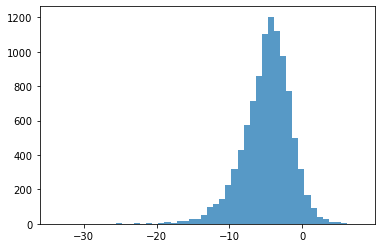

In [17]:
plt.hist(np_outputs, 50, alpha=0.75)
plt.show()

## iSIR

In [28]:
def compute_sir_log_weights(x, target, proposal):
    return target(x) - proposal.log_prob(x)

def sir_independent_dynamics_update(z, target, proposal, n_steps, N):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    
    diff_history = []

    for _ in tqdm(range(n_steps)):
        z_sp.append(z)
        z_old = z.clone().detach()
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
      
        max_logs = torch.max(log_weight, dim=1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim=1)
        weight = weight/sum_weight[:, None]

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        diff = float((torch.norm(z.clone() - z_old, dim = 1) < 1e-10).sum())/batch_size
        
        diff_history.append(diff)

    z_sp.append(z)
    return z_sp, diff_history

In [29]:
N = 5
n_steps = 100
batch_size = 100
z_start = torch.randn(batch_size, dim).to(device)

z_sp, diff_history = sir_independent_dynamics_update(z_start, target_gan, proposal, n_steps, N)

100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


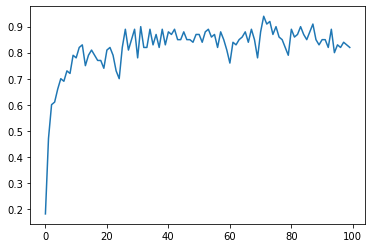

In [30]:
plt.plot([i for i in range(len(diff_history))], diff_history)